<h2><b>Importing libraries</b></h2>

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import mplfinance as mpf
from pandas_datareader import data
import matplotlib.dates as mdates
import seaborn as sns
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score
from sklearn.metrics import mean_absolute_error, roc_curve, auc
from sklearn.metrics import mean_squared_error
import math
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
import time
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<h2><b>Getting data</b></h2>

In [2]:
histEmbr = web.DataReader('EMBR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histOi = web.DataReader('OIBR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histMglu = web.DataReader('MGLU3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histAmbv = web.DataReader('ABEV3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histBB = web.DataReader('BBAS3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histVale = web.DataReader('VALE3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histPetro = web.DataReader('PETR4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histFlry = web.DataReader('FLRY3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
histCgas = web.DataReader('CGAS5.SA', data_source='yahoo', start="2018-01-01", end="2018-12-31")
# histRio = web.DataReader('VVAR3.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")
# histOSX = web.DataReader('BBDC4.SA', data_source='yahoo', start="2018-01-01", end="2018-12-30")

In [3]:
# historicStock = [histVale, histAzul, histBB, histPetro, histItau, histRio, histOSX]
historicStock = [histEmbr, histOi, histMglu, histAmbv, histBB, histVale, histPetro, histFlry, histCgas]

In [4]:
historicStock[0].head()

High        Low       Open      Close     Volume  Adj Close
Date                                                                        
2018-01-02  20.990000  20.230000  20.629999  20.520000  3813300.0  20.389370
2018-01-03  21.600000  20.860001  21.049999  21.299999  9403700.0  21.164400
2018-01-04  22.200001  21.500000  21.500000  21.799999  6597700.0  21.661217
2018-01-05  22.129999  20.650000  21.900000  20.650000  8980400.0  20.518539
2018-01-08  21.170000  20.500000  21.059999  20.700001  4798500.0  20.568220

In [5]:
monthlyInflation2018 = [0.0076, 0.0007, 0.0064, 0.0057, 0.0138, 0.0187, 0.0051, 0.0070, 0.0152, 0.0089, -0.0049, -0.0108]

<h2><b>Calculating daily inflation</b></h2>

In [6]:
dayMonth30 = [4,6,9,11]
dayMonth31 = [1,3,5,7,8,10,12]
        
def calculate_daily_inflation(monthlyInflation):
    dailyInflation = []
    inflationHigh = []
    inflationLow = []
    inflationOpen = []
    inflationClose = []
    
    for index, inf in enumerate(monthlyInflation):
        if np.isin(index, dayMonth30):
            dailyInflation.append((1 + inf) ** (1/float(30)))
        elif np.isin(index, dayMonth31):
            dailyInflation.append((1 + inf) ** (1/float(31)))
        else:
            dailyInflation.append((1 + inf) ** (1/float(28)))
    
    for stock in historicStock:
        stock["Month"] = stock.index.month
        total = 1
        inflation = []
        for index, row in stock.iterrows():
            month = int(row['Month'])
            if dailyInflation[month - 1] >= 1:
                total = total * dailyInflation[month - 1]
            else:
                total = total / dailyInflation[month - 1]
            inflation.append(total)
        stock["DailyInflation"] = inflation
        
    for stock in historicStock:
        for index, row in stock.iterrows():
            inflationHigh = round(stock["High"] / stock["DailyInflation"], 2)
            inflationLow = round(stock["Low"] / stock["DailyInflation"], 2)
            inflationOpen = round(stock["Open"] / stock["DailyInflation"], 2)
            inflationClose = round(stock["Close"] / stock["DailyInflation"], 2) 
        stock["InflationHigh"] = inflationHigh
        stock["InflationLow"] = inflationLow
        stock["InflationOpen"] = inflationOpen
        stock["InflationClose"] = inflationClose

In [7]:
calculate_daily_inflation(monthlyInflation2018)

<h2><b>Calculating short and long EMAs, MACD and Signal lines</b></h2>

In [8]:
def calculate_lines():
    for stock in historicStock:
        stock["ShortEMA"] = stock["Close"].ewm(span = 12, adjust = False).mean()
        stock["LongEMA"] = stock["Close"].ewm(span = 26, adjust = False).mean()
        stock["MACD"] = stock["ShortEMA"] - stock["LongEMA"]
        stock["Signal"] = stock["MACD"].ewm(span = 9, adjust = False).mean()
        stock["InflationShortEMA"] = stock["InflationClose"].ewm(span = 12, adjust = False).mean()
        stock["InflationLongEMA"] = stock["InflationClose"].ewm(span = 26, adjust = False).mean()
        stock["InflationMACD"] = stock["InflationShortEMA"] - stock["InflationLongEMA"]
        stock["InflationSignal"] = stock["InflationMACD"].ewm(span = 9, adjust = False).mean()

In [9]:
calculate_lines()

In [10]:
def plot_emas(stocks, inflation=False):
    for stock in stocks:
        plt.figure(figsize = (14,10))
        plt.plot(stock["ShortEMA"], label="ShortEMA")
        plt.plot(stock["LongEMA"], label="LongEMA")
        plt.plot(stock["Close"], label="Close", alpha=0.3)
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Valores/Preço')
        plt.title("EMAs")
        plt.show()

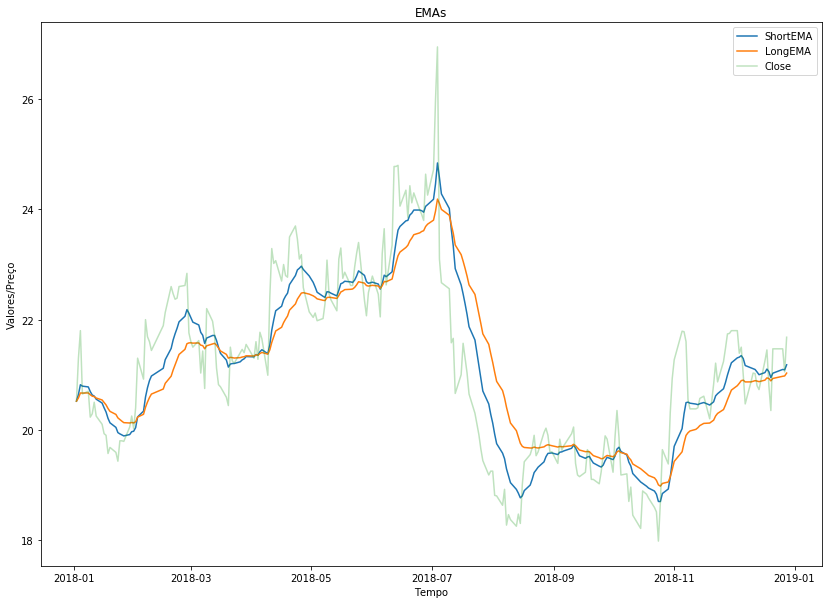

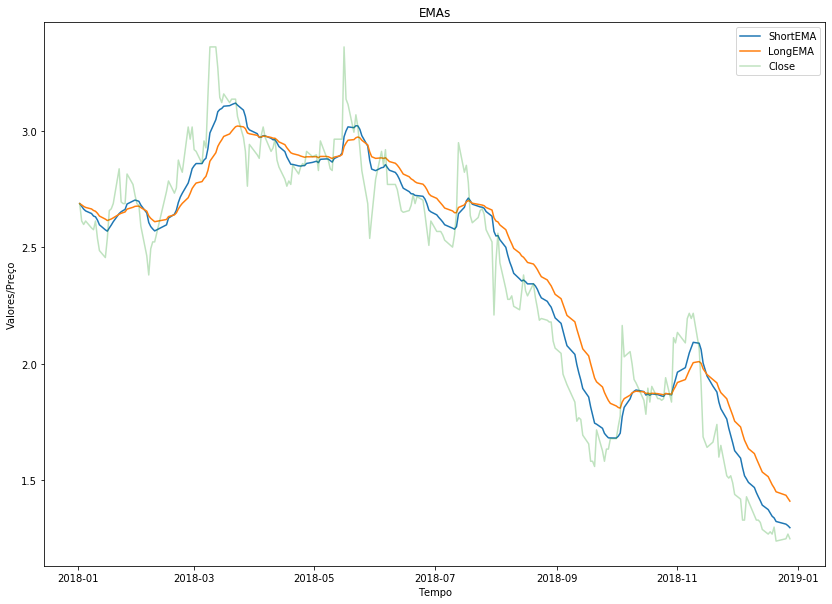

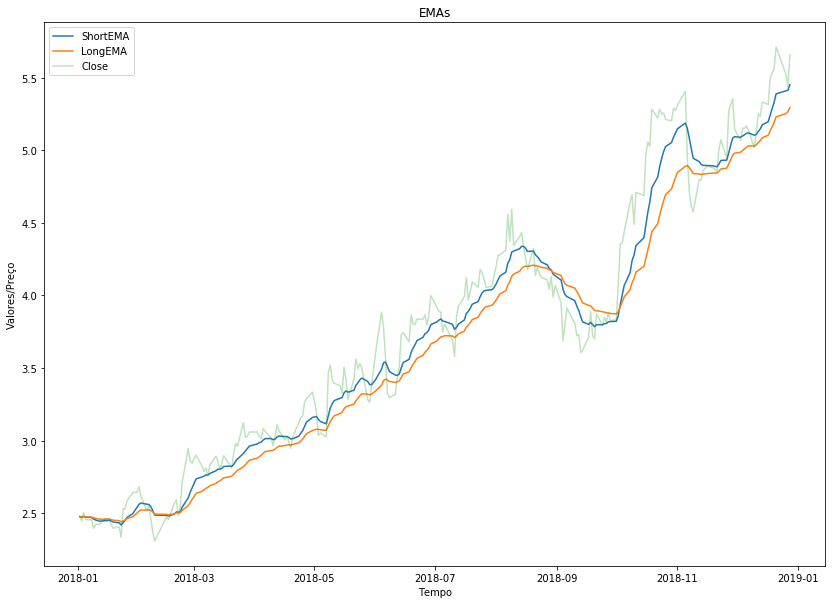

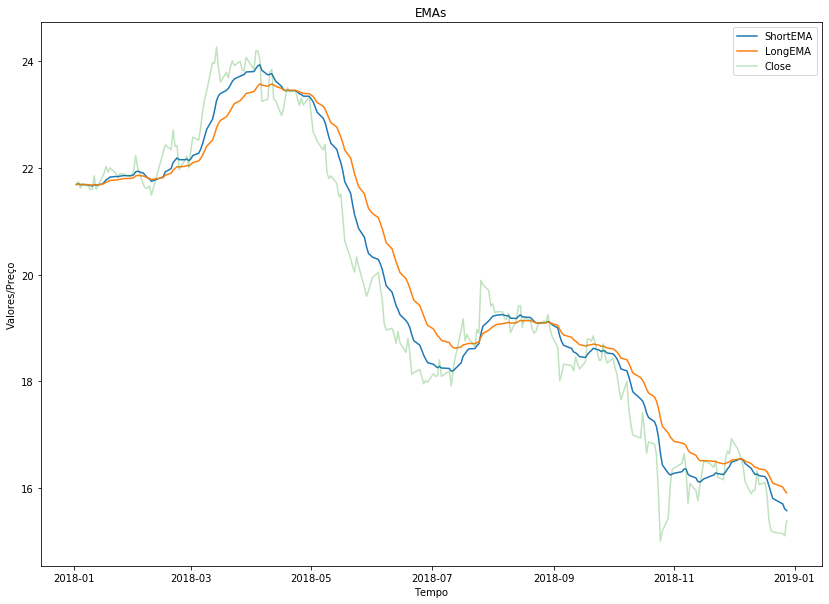

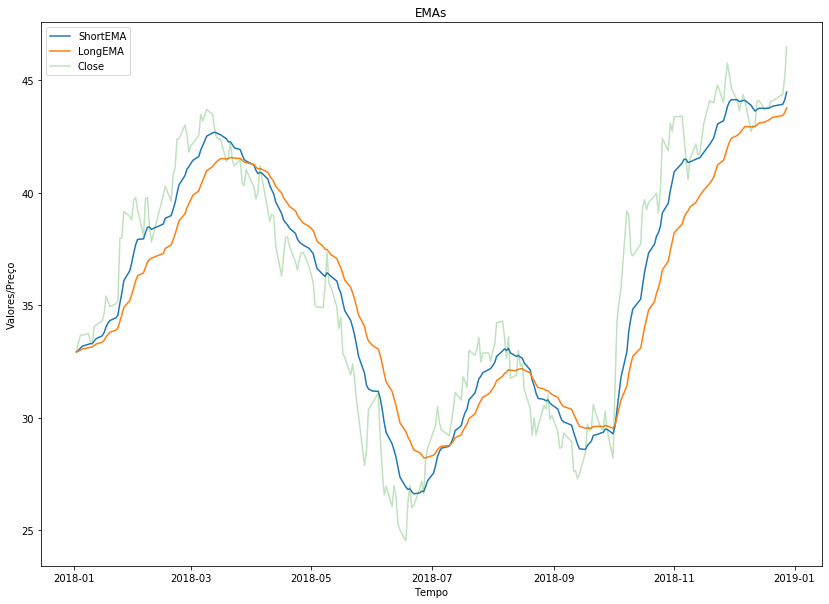

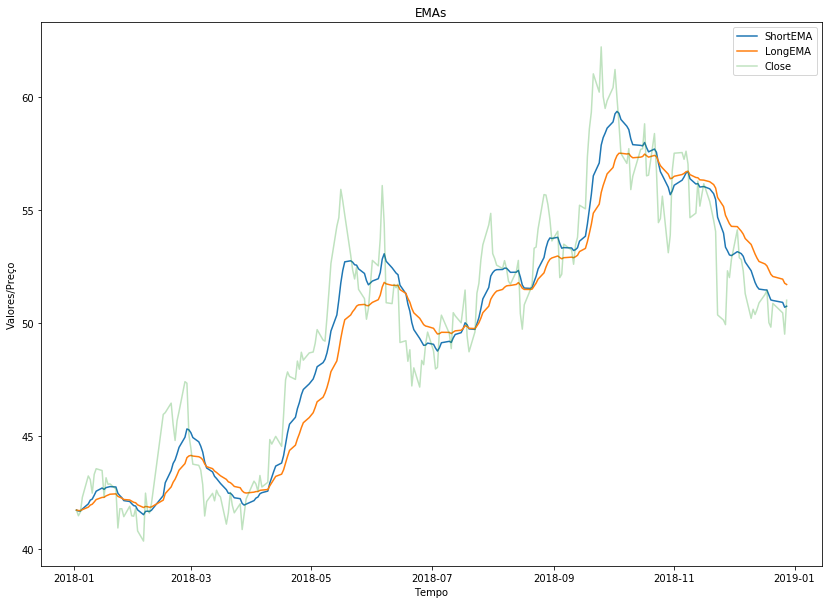

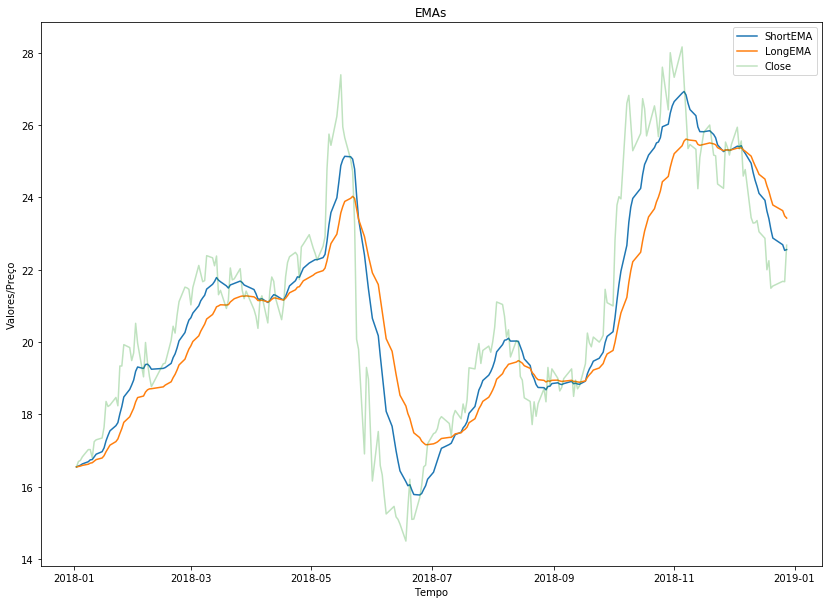

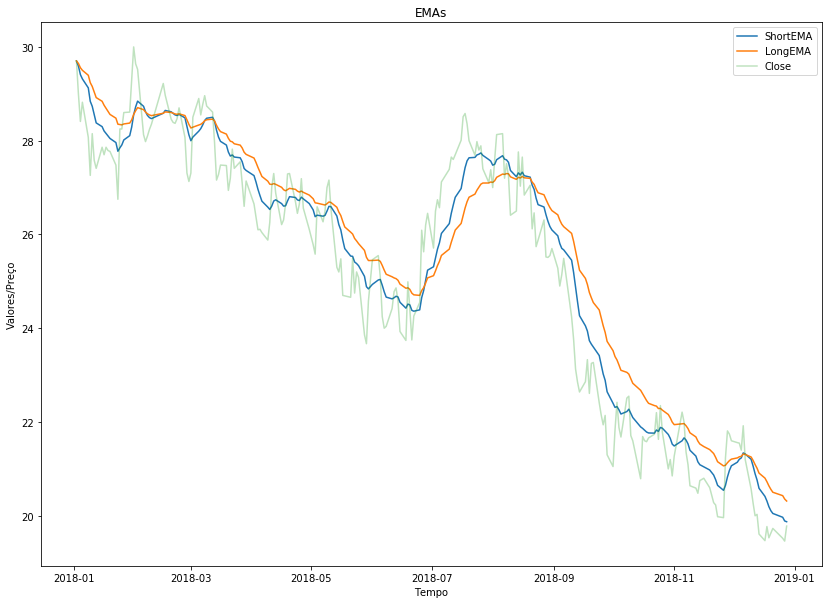

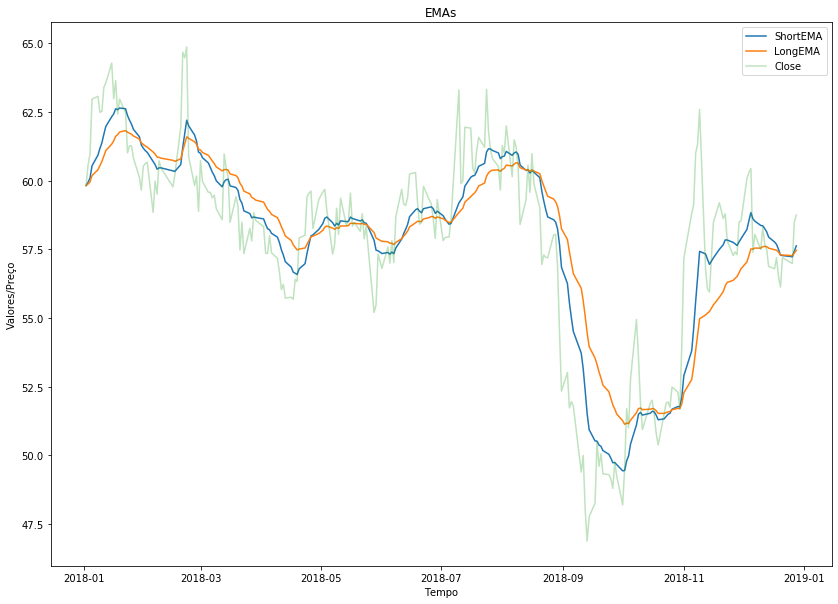

In [11]:
plot_emas(historicStock)

In [12]:
def plot_macd_signal(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)
        plt.figure(figsize = (14,10))
        if inflation == False:
            ax = stockScaled["MACD"].plot()
            ax = stockScaled["Signal"].plot()
            stockScaled["Close"].plot(alpha=0.3)
        else:
            ax = stockScaled["InflationMACD"].plot()
            ax = stockScaled["InflationSignal"].plot()
            stockScaled["InflationClose"].plot(alpha=0.3)
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço')
        plt.title("MACD e Signal")
        plt.show()

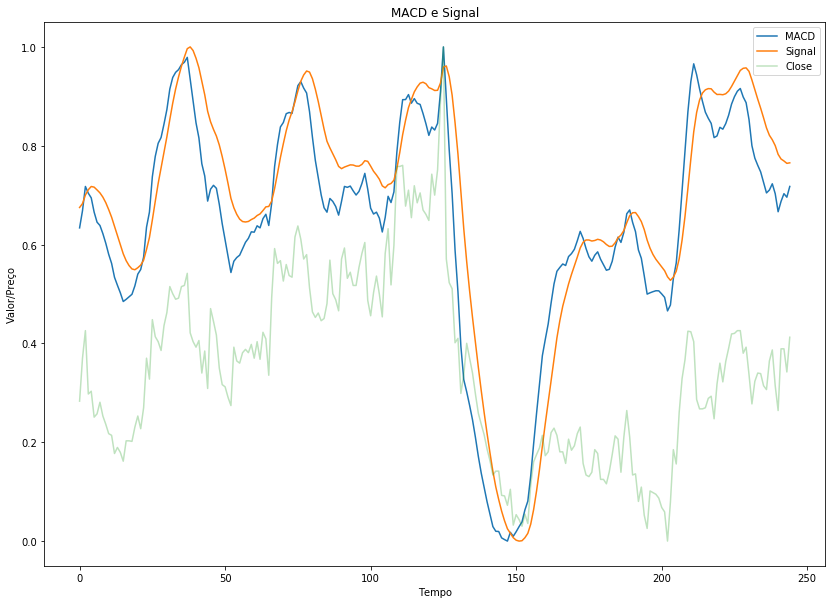

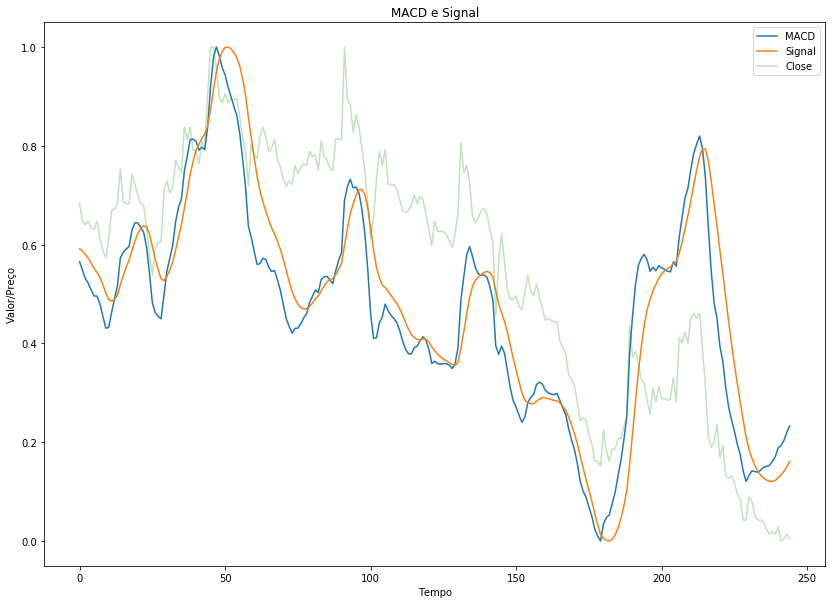

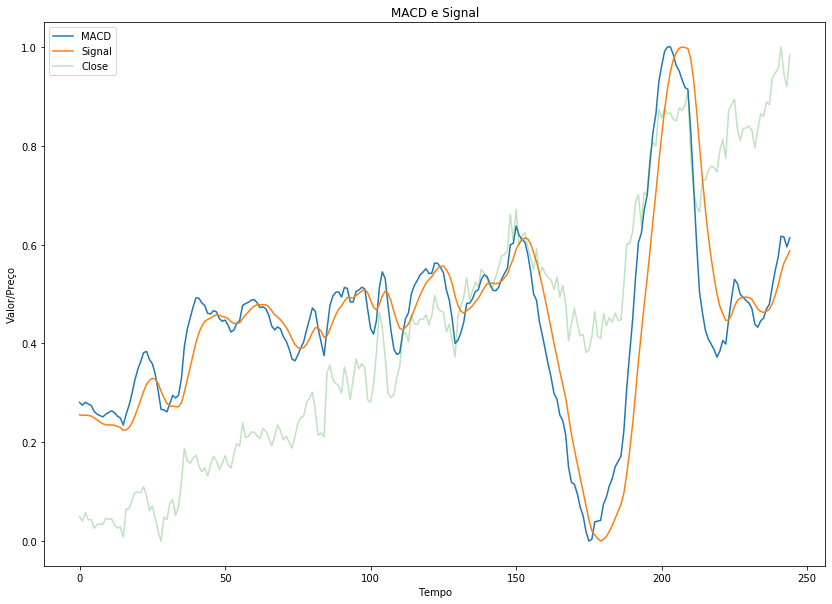

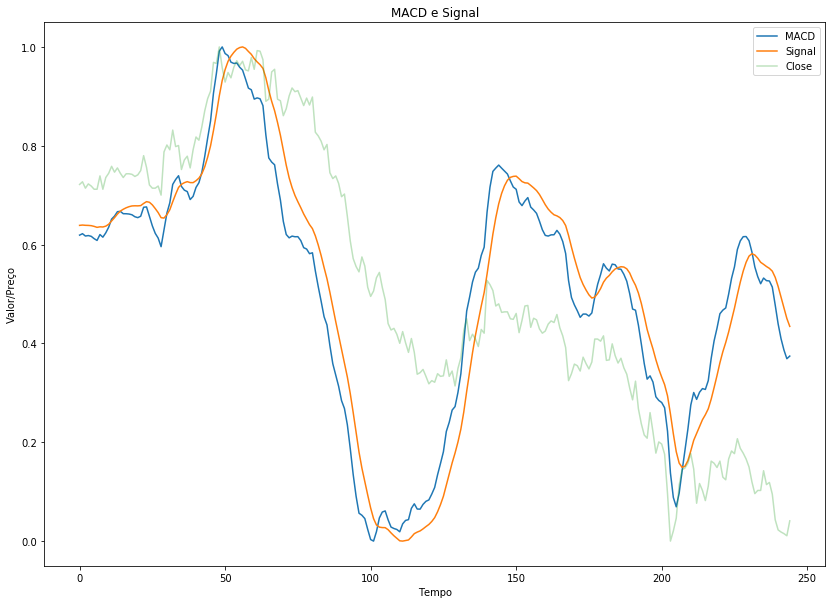

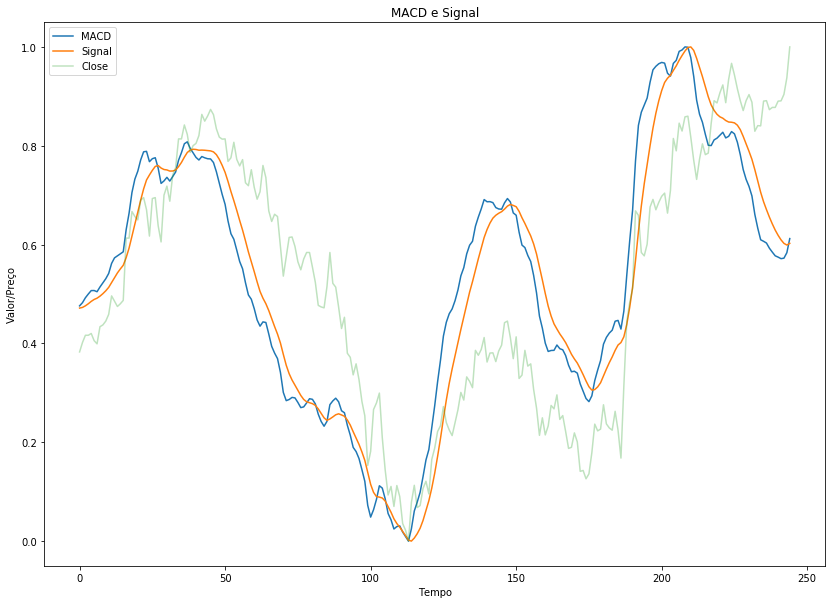

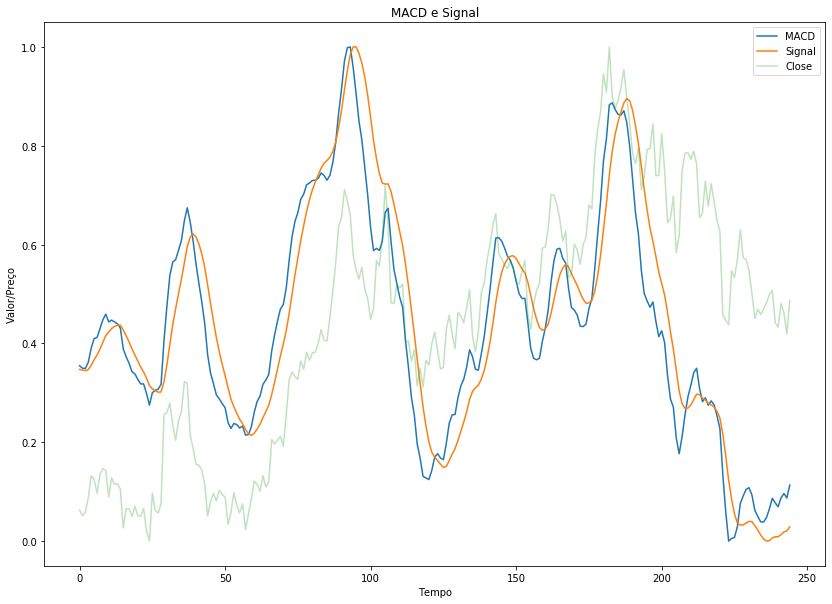

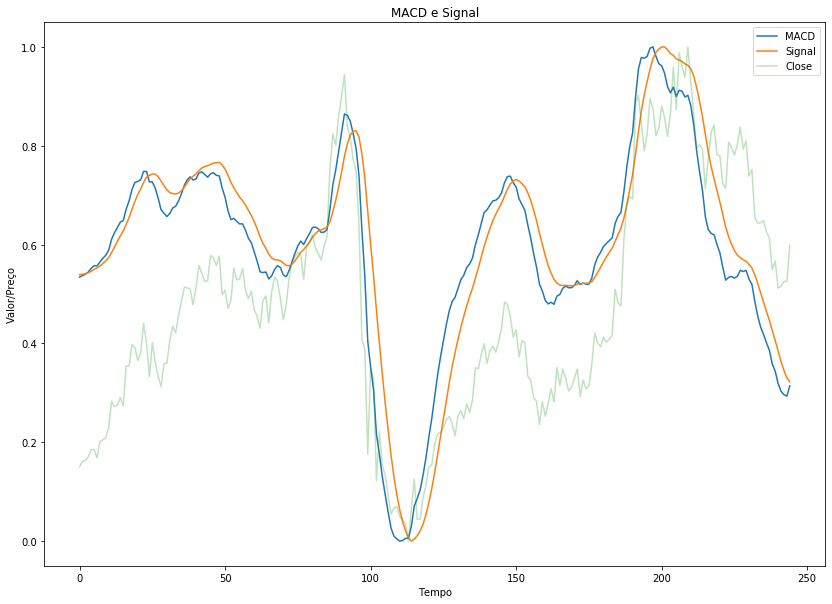

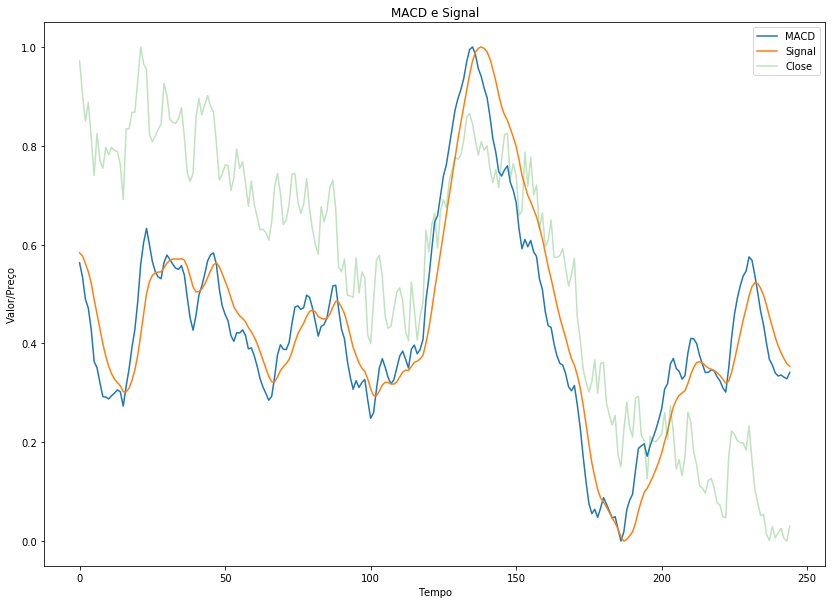

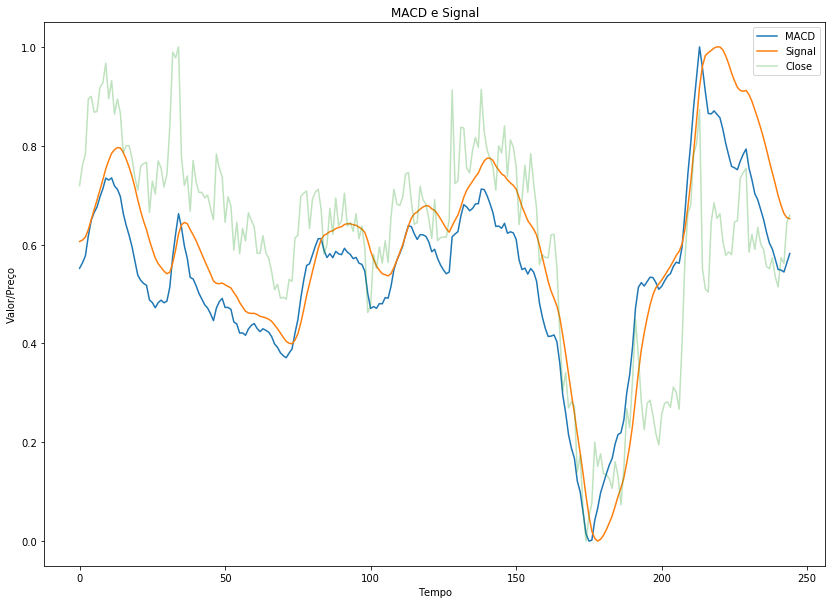

In [13]:
plot_macd_signal(historicStock)

In [14]:
def calculate_bollinger_bands():
    for stock in historicStock:
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
        
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]
        
        plt.figure(figsize = (14,10))
        plt.plot(stock["LowerBollinger"], label="Lower")
        plt.plot(stock["UpperBollinger"], label="Upper")
        plt.plot(stock["Close"], label="Close")
        plt.legend()
        plt.xlabel('Tempo')
        plt.ylabel('Preço')
        plt.title("Bandas de Bollinger")
        plt.show()

In [15]:
def calculate_bollinger_bands_stock(stock, inflation=False):
    if(inflation == False):
        stock["30_MA"] = stock["Close"].rolling(window=20).mean()
        stock["30_STD"] = stock["Close"].rolling(window=20).std()
        stock["UpperBollinger"] = stock["30_MA"] + 2 * stock["30_STD"]
        stock["LowerBollinger"] = stock["30_MA"] - 2 * stock["30_STD"]
        stock["DifferenceUpper"] = stock["UpperBollinger"] - stock["Close"]
        stock["DifferenceLower"] = stock["LowerBollinger"] - stock["Close"]
    else:
        stock["Inflation30_MA"] = stock["InflationClose"].rolling(window=20).mean()
        stock["Inflation30_STD"] = stock["InflationClose"].rolling(window=20).std()
        stock["InflationUpperBollinger"] = stock["Inflation30_MA"] + 2 * stock["Inflation30_STD"]
        stock["InflationLowerBollinger"] = stock["Inflation30_MA"] - 2 * stock["Inflation30_STD"]
        stock["InflationDifferenceUpper"] = stock["InflationUpperBollinger"] - stock["InflationClose"]
        stock["InflationDifferenceLower"] = stock["InflationLowerBollinger"] - stock["InflationClose"]

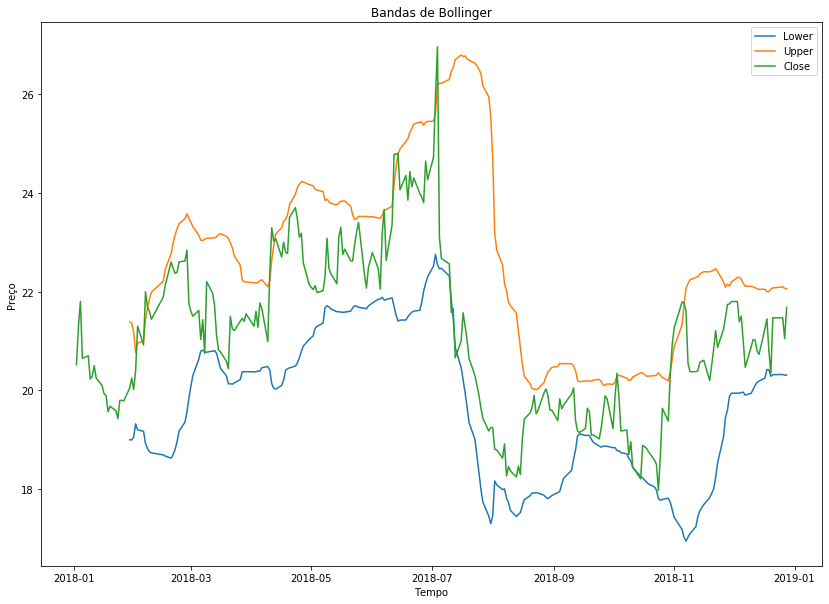

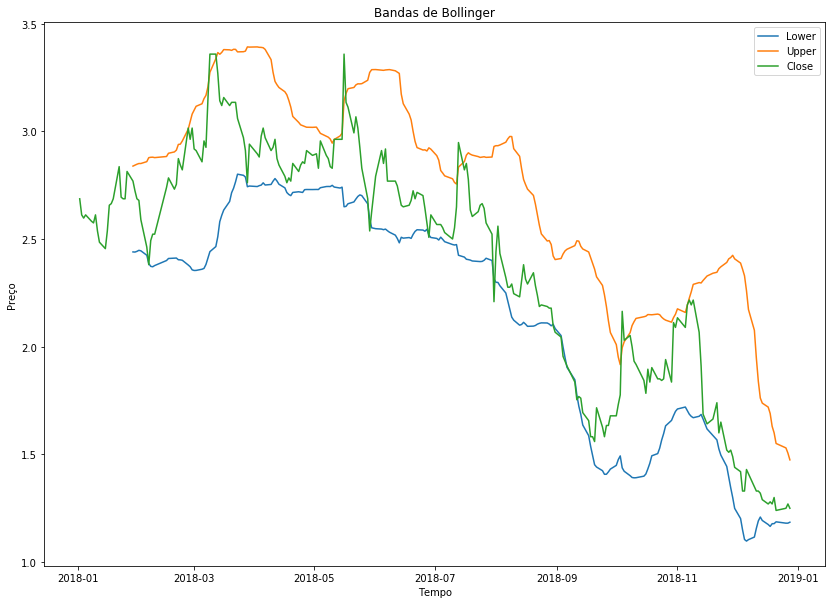

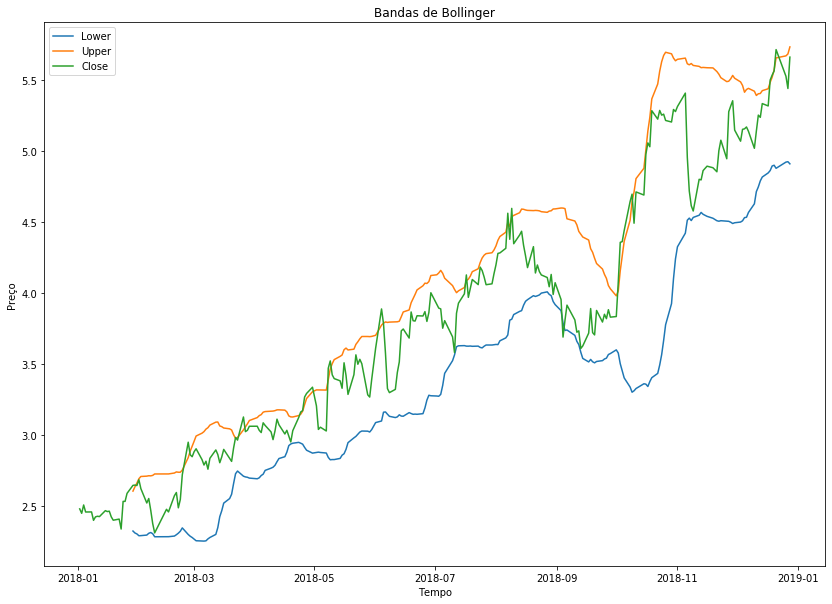

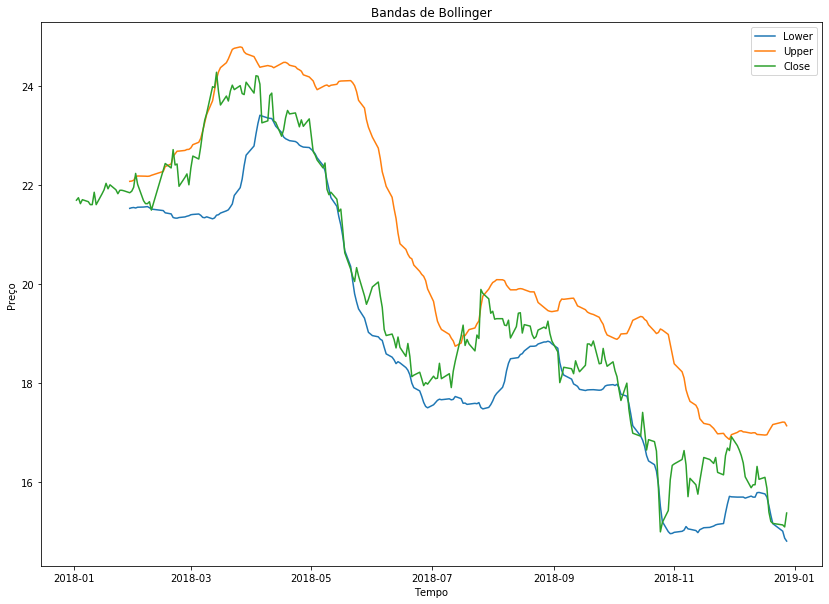

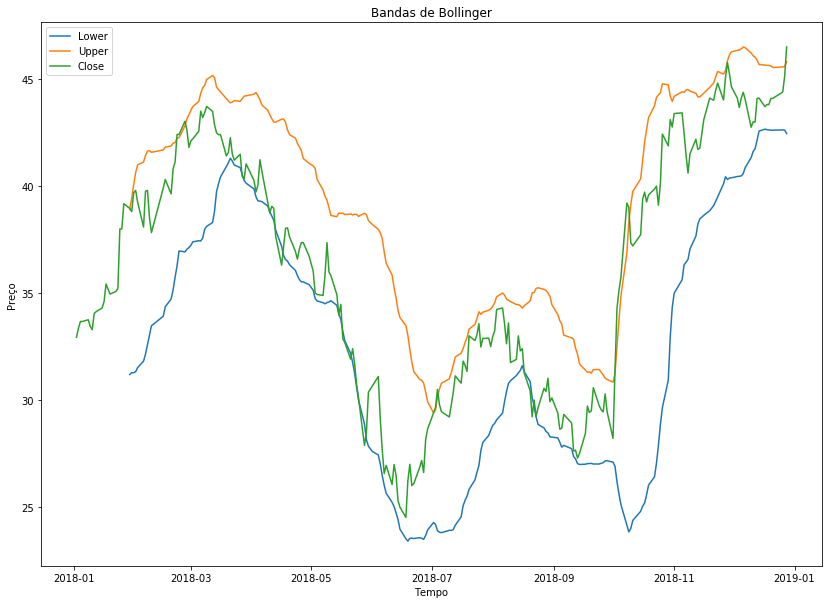

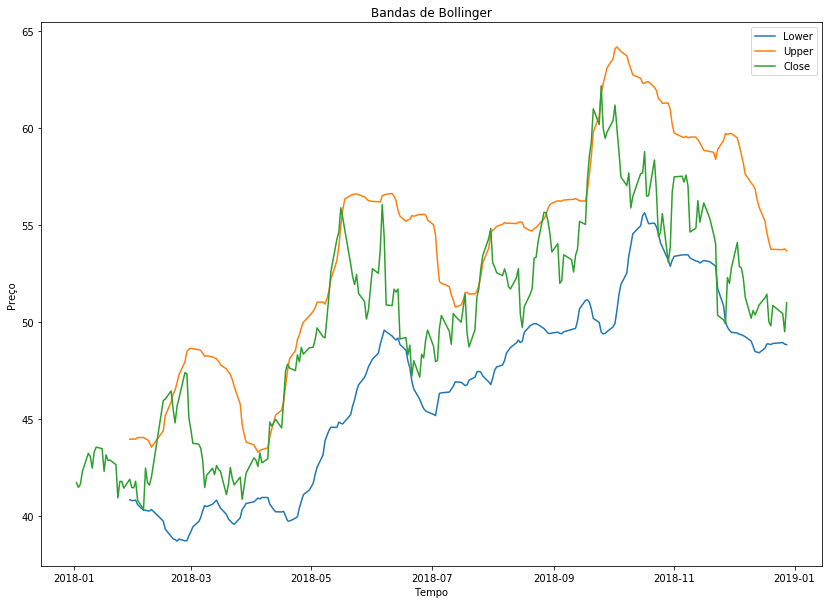

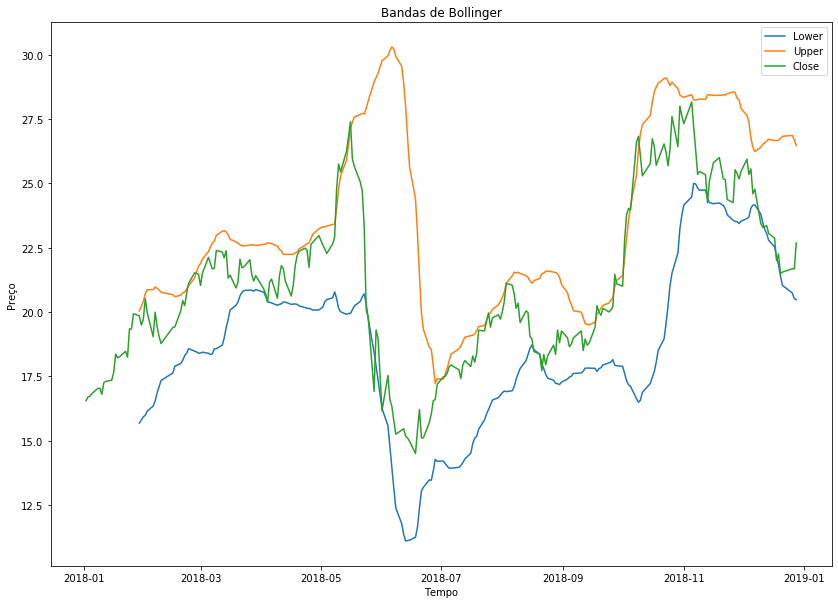

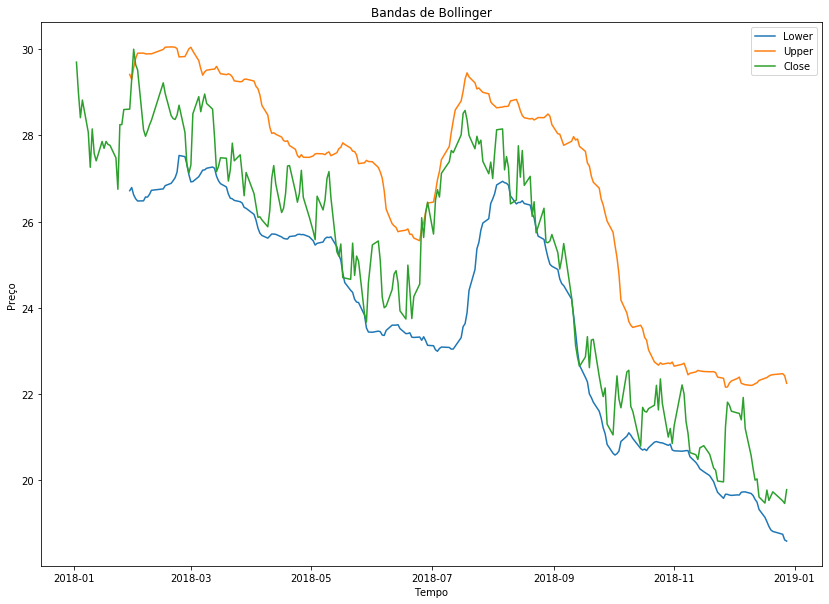

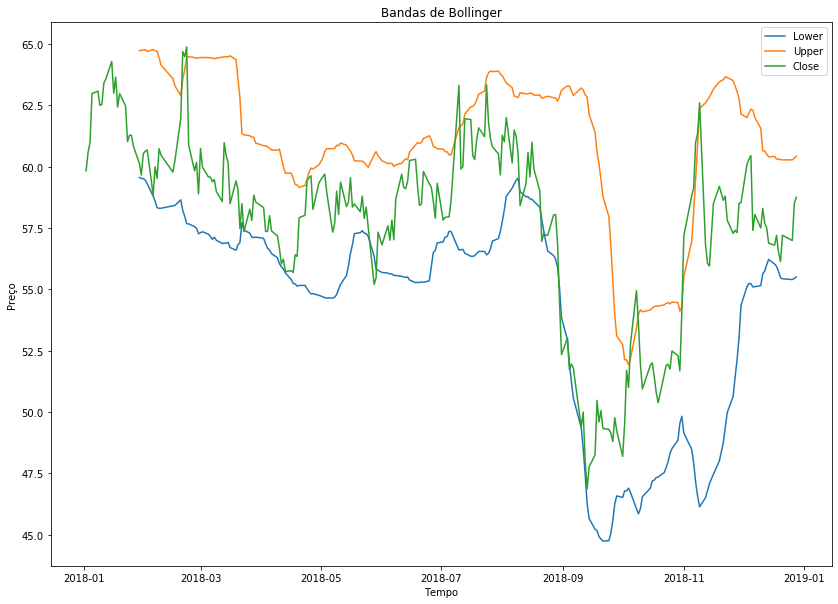

In [16]:
calculate_bollinger_bands()

In [17]:
def upOrDown():
    for stock in historicStock:
        stock["UpDown"] = stock["Close"].diff();
        stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [18]:
def upOrDownNpArray(array):
    difference = np.diff(array)
    diffReturn = []
    for i in difference:
        if i >= 0:
            diffReturn.append(1)
        else:
            diffReturn.append(0)
    return np.array(diffReturn)

In [19]:
def upOrDownStock(stock):
    stock["UpDown"] = stock["Close"].diff();
    stock["UpDown"] = stock["UpDown"].apply(lambda x: 1 if x >= 0 else 0)

In [20]:
upOrDown()

<h2><b>Calculating Relative Strength Index (RSI)</b></h2>

In [21]:
def calculate_RSI(window):
    for stock in historicStock:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
        
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [22]:
def calculate_RSI_stock(window, stock, inflation=False):
    if inflation == False:
        delta = stock["Close"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["RSI"] = rsi
    else:
        delta = stock["InflationClose"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        RS_up = up_days.rolling(window).mean()
        RS_down = down_days.rolling(window).mean()
        rsi= 100-100/(1+RS_up/RS_down)
        stock["InflationRSI"] = rsi

In [23]:
calculate_RSI(14)

<h2><b>Function to plot RSI</b></h2>

In [24]:
def plot_rsi_close(stock, stockName, inflation=False):
    scaler = MinMaxScaler()
    stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stockScaled["RSI"].plot()
        stockScaled["Close"].plot()
    else:
        ax = stockScaled["InflationRSI"].plot()
        stockScaled["InflationClose"].plot()
    ax.axhline(y = 0.7, color = 'red')
    ax.axhline(y = 0.3, color = 'lime')
    plt.title(f'Relação RSI e Close da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Valor/Preço')
    plt.legend()
    plt.show()

In [25]:
def plot_rsi_close_all_stocks(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)

        plt.figure(figsize = (14, 10))
        if inflation == False:
            ax = stockScaled["RSI"].plot()
            stockScaled["Close"].plot()
        else:
            ax = stockScaled["InflationRSI"].plot()
            stockScaled["InflationClose"].plot()
        ax.axhline(y = 0.7, color = 'red')
        ax.axhline(y = 0.3, color = 'lime')
        plt.title('Relação RSI e Close')
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço normalizado')
        plt.legend()
        plt.show()

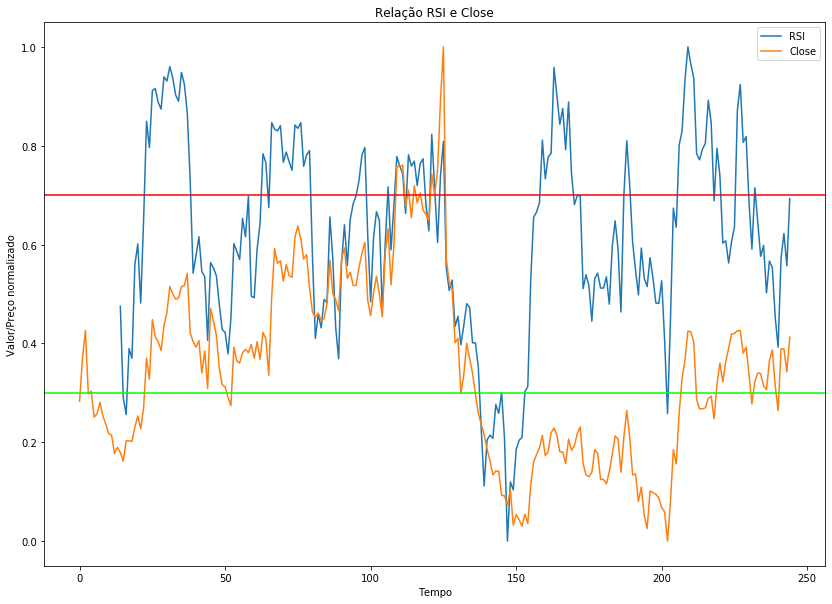

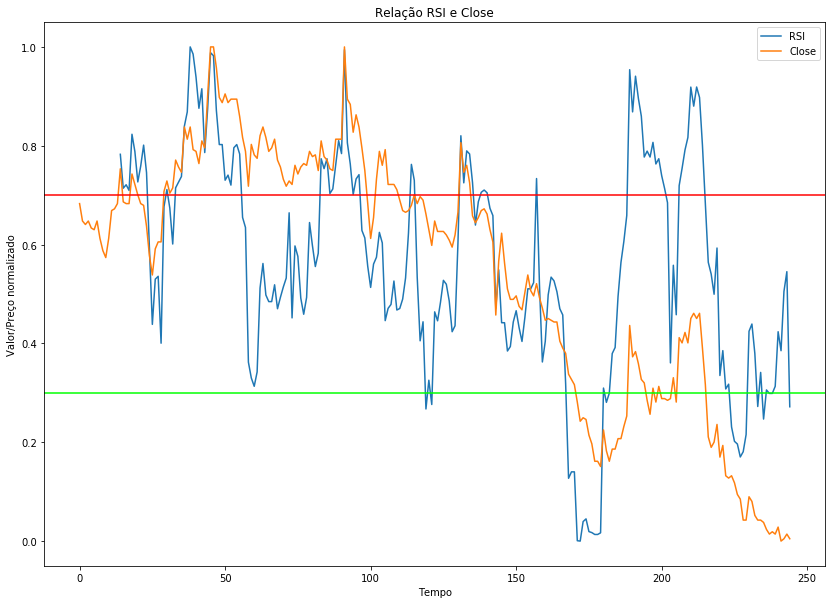

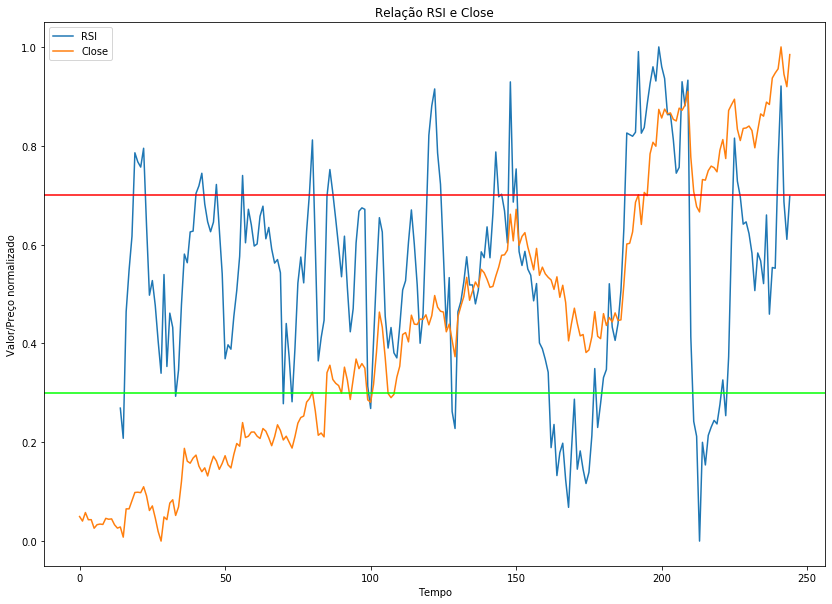

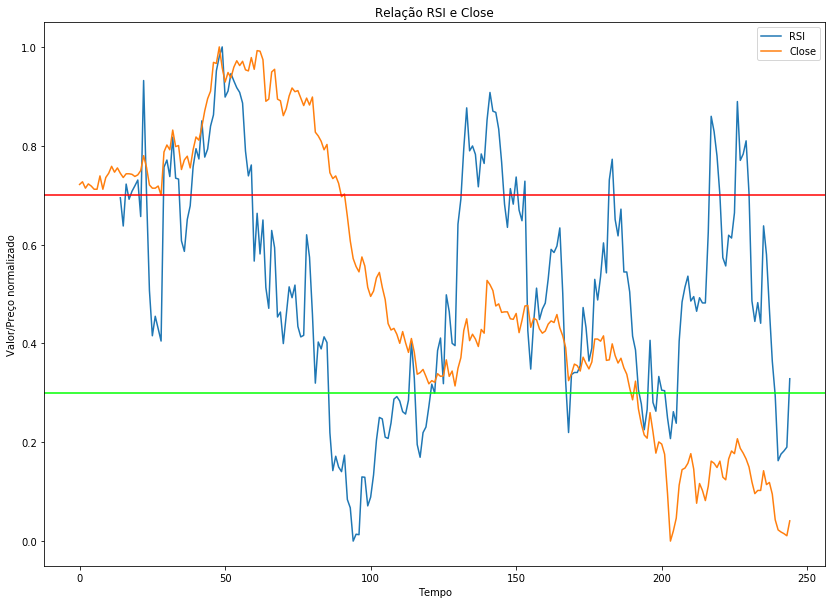

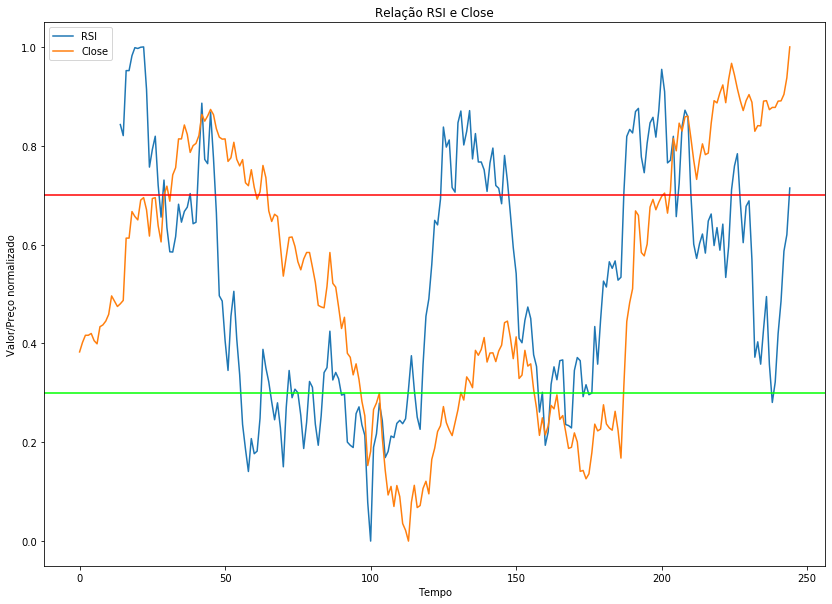

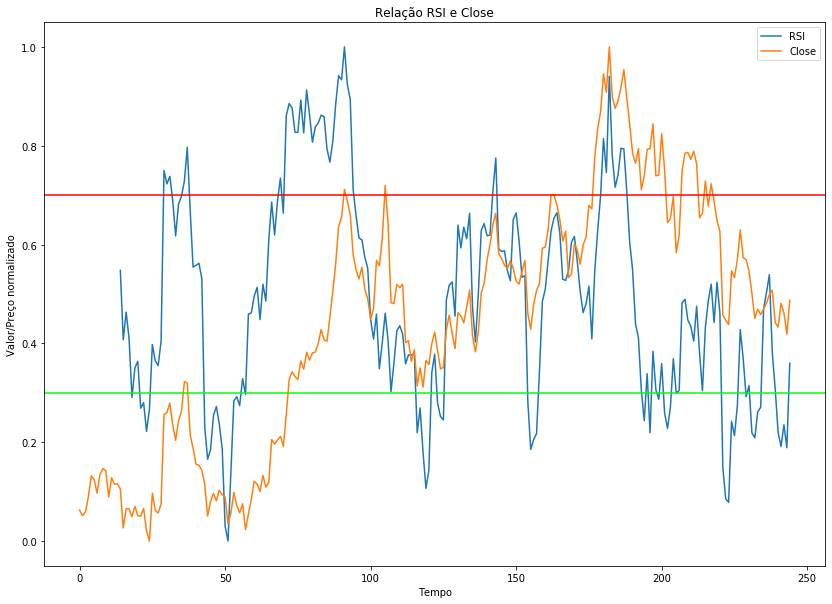

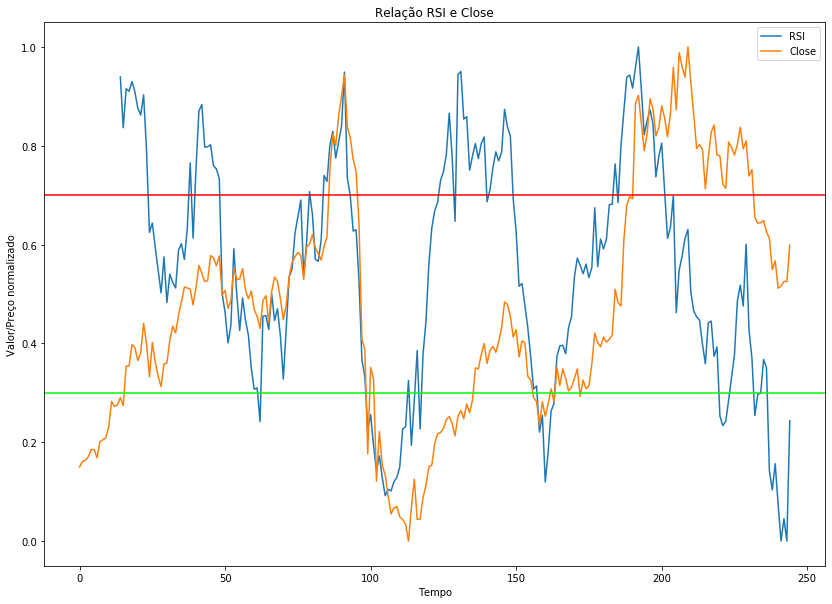

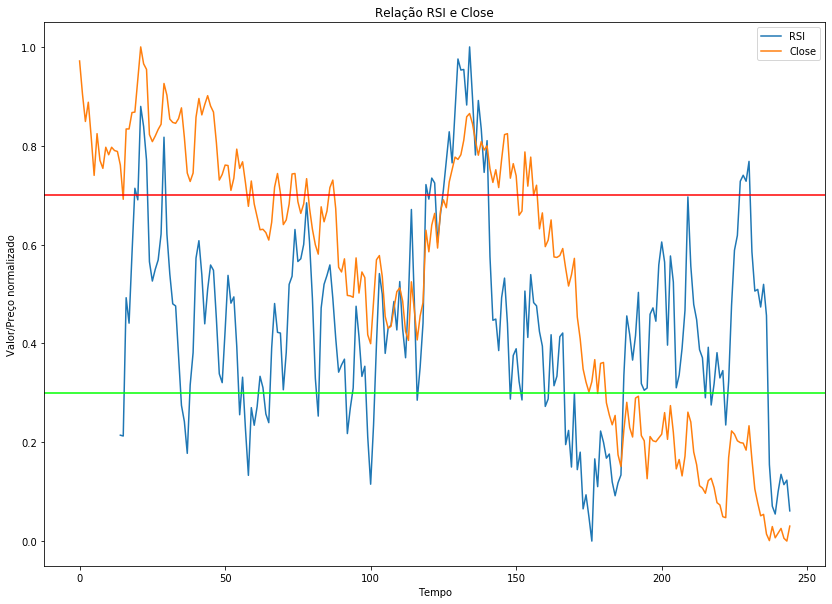

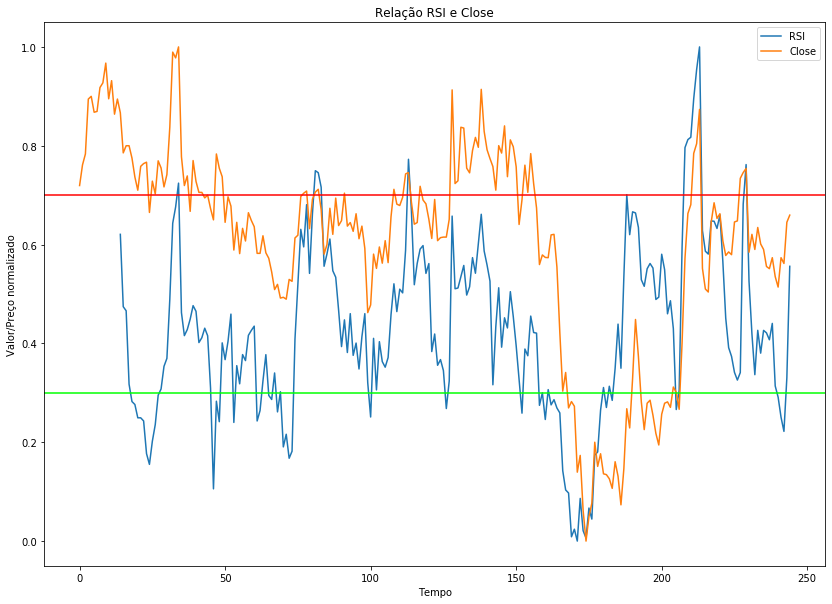

In [26]:
plot_rsi_close_all_stocks(historicStock)

<h2><b>Calculating Money Flow Index (MFI)</b></h2>

In [27]:
def calculate_MFI(window):
    for stock in historicStock:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))

        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [28]:
def calculate_MFI_stock(window, stock, inflation=False):
    if inflation == False:
        stock["TypicalPrice"] = (stock["High"] + stock["Low"] + stock["Close"]) / 3
        delta = stock["TypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["TypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["TypicalPrice"]
        stock["1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["nDayPositiveMoneyFlow"] = stock["1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["nDayNegativeMoneyFlow"] = stock["1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["MoneyFlowRatio"] = stock["nDayPositiveMoneyFlow"] / stock["nDayNegativeMoneyFlow"]
        stock["MoneyFlowIndex"] = 100 - (100 / (1 + stock["MoneyFlowRatio"]))
    else:
        stock["InflationTypicalPrice"] = (stock["InflationHigh"] + stock["InflationLow"] + stock["InflationClose"]) / 3
        delta = stock["InflationTypicalPrice"].diff()
        up_days = delta.copy()
        up_days[delta<=0]=0.0
        up_days[delta>0]=stock["InflationTypicalPrice"]
        down_days = abs(delta.copy())
        down_days[delta>0]=0.0
        down_days[delta<=0]=stock["InflationTypicalPrice"]
        stock["Inflation1DayPositiveMoneyFlow"] = up_days * stock["Volume"]
        stock["Inflation1DayNegativeMoneyFlow"] = down_days * stock["Volume"]
        stock["InflationnDayPositiveMoneyFlow"] = stock["Inflation1DayPositiveMoneyFlow"].rolling(window).sum()
        stock["InflationnDayNegativeMoneyFlow"] = stock["Inflation1DayNegativeMoneyFlow"].rolling(window).sum()
        stock["InflationMoneyFlowRatio"] = stock["InflationnDayPositiveMoneyFlow"] / stock["InflationnDayNegativeMoneyFlow"]
        stock["InflationMoneyFlowIndex"] = 100 - (100 / (1 + stock["InflationMoneyFlowRatio"]))

In [29]:
calculate_MFI(14)

<h2><b>Function to plot MFI</b></h2>

In [30]:
def plot_mfi(stock, stockName, inflation=False):

    plt.figure(figsize = (20, 10))
    if inflation == False:
        ax = stock["MoneyFlowIndex"].plot()
    else:
        ax = stock["InflationMoneyFlowIndex"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'MFI da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

<h2><b>Calculating Stochastic Oscillator</b></h2>

In [31]:
def calculate_stochastic_oscillator(window):
    for stock in historicStock:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
        
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [32]:
def calculate_stochastic_oscillator_stock(window, stock, inflation=False):
    if inflation == False:
        nHigh = stock["High"].rolling(window).max()
        nLow = stock["Low"].rolling(window).min()
        stock["StochasticOscillator"] = ((stock["Close"] - nLow) / (nHigh - nLow)) * 100
    else:  
        nHigh = stock["InflationHigh"].rolling(window).max()
        nLow = stock["InflationLow"].rolling(window).min()
        stock["InflationStochasticOscillator"] = ((stock["InflationClose"] - nLow) / (nHigh - nLow)) * 100

In [33]:
calculate_stochastic_oscillator(14)

<h2><b>Function to plot Stochastic Oscillator</b></h2>

In [34]:
def plot_stochastic_oscillator(stock, stockName, inflation=False):

    plt.figure(figsize = (14, 10))
    if inflation == False:
        ax = stock["StochasticOscillator"].plot()
    else:
        ax = stock["InflationStochasticOscillator"].plot()
    ax.axhline(y = 20, color = 'red')
    ax.axhline(y = 80, color = 'lime')
    plt.title(f'Oscilador estocástico da {stockName}')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.legend()
    plt.show()

In [35]:
def plot_stochastic_oscillator_all_stocks(stocks, inflation=False):
    for stock in stocks:
        scaler = MinMaxScaler()
        stockScaled = pd.DataFrame(scaler.fit_transform(stock), columns=stock.columns)
        plt.figure(figsize = (14, 10))
        if inflation == False:
            ax = stockScaled["StochasticOscillator"].plot()
            stockScaled["Close"].plot()
        else:
            ax = stockScaled["InflationStochasticOscillator"].plot()
            stockScaled["InflationClose"].plot()
        ax.axhline(y = 0.2, color = 'red')
        ax.axhline(y = 0.8, color = 'lime')
        plt.title('Oscilador estocástico')
        plt.xlabel('Tempo')
        plt.ylabel('Valor/Preço')
        plt.legend()
        plt.show()

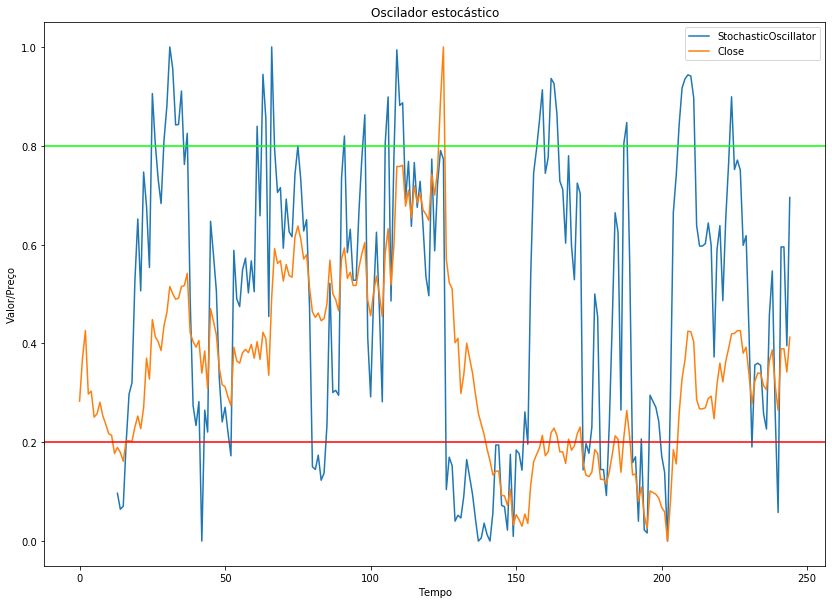

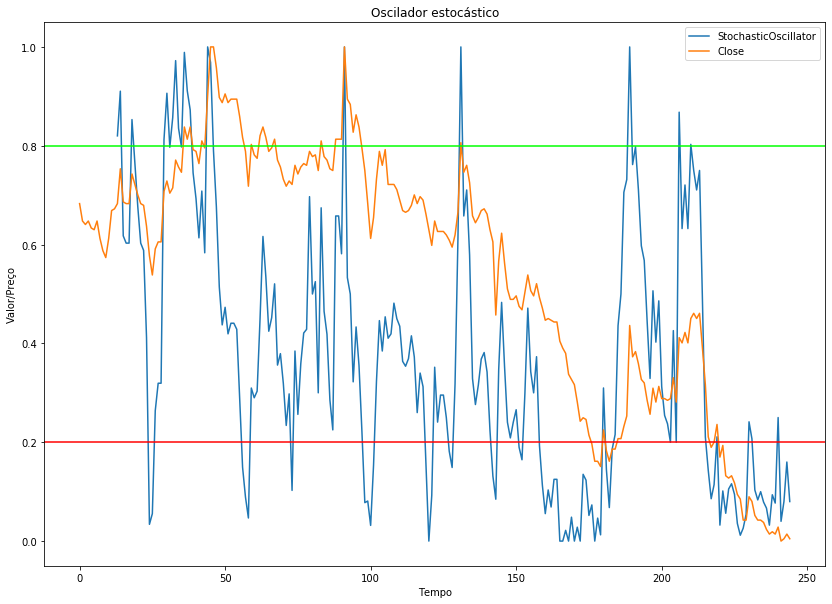

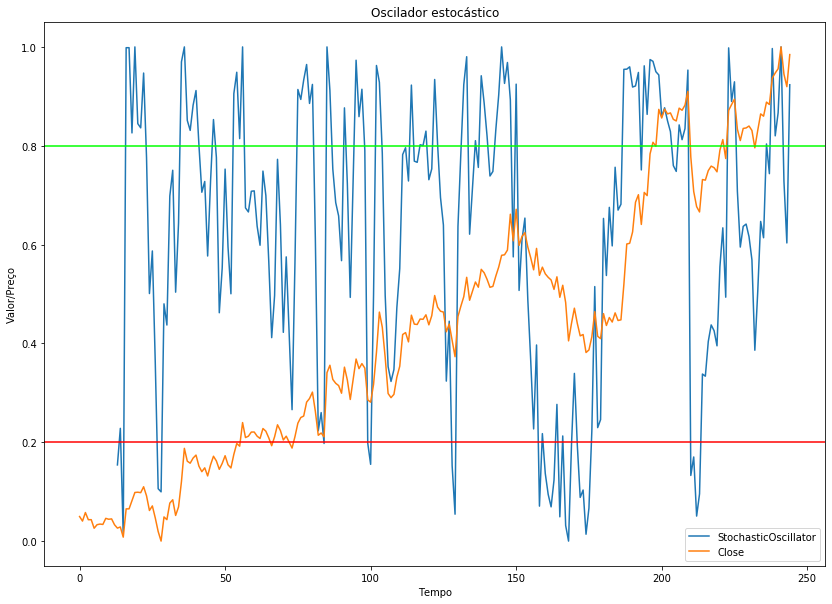

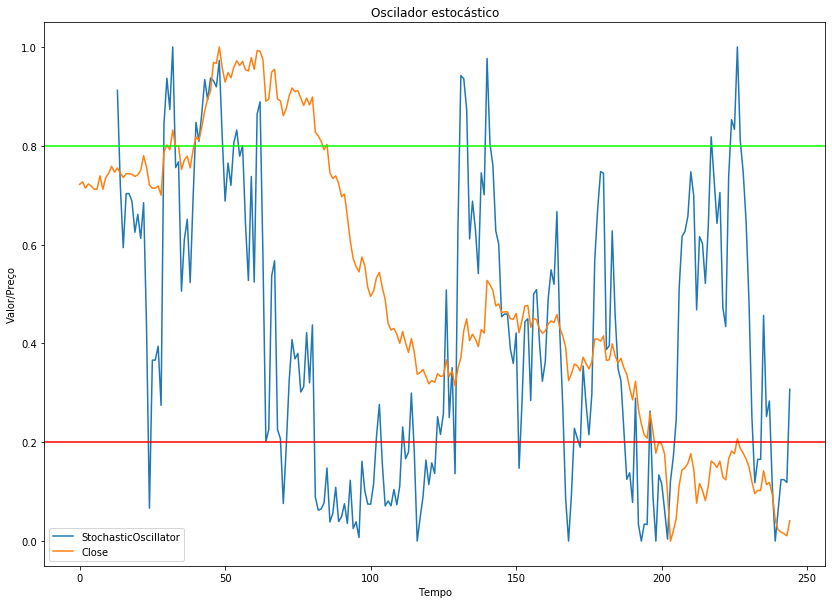

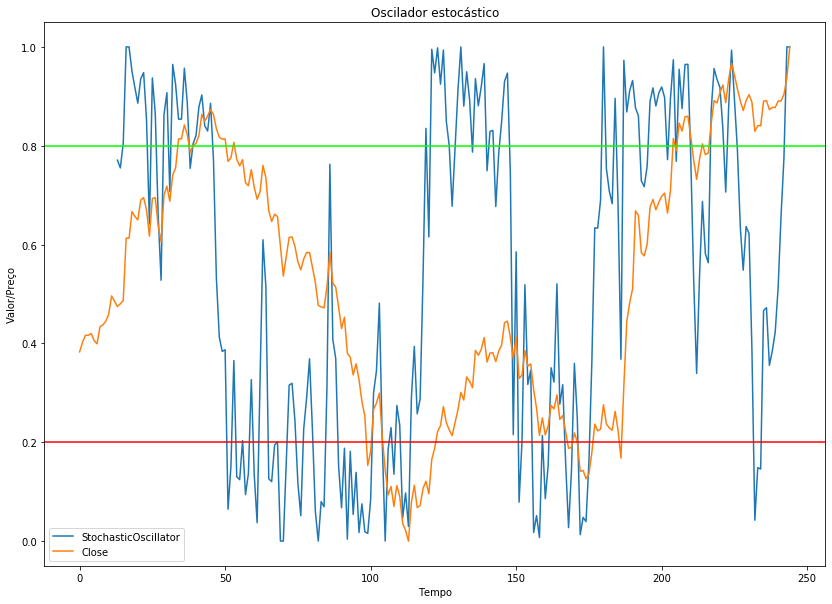

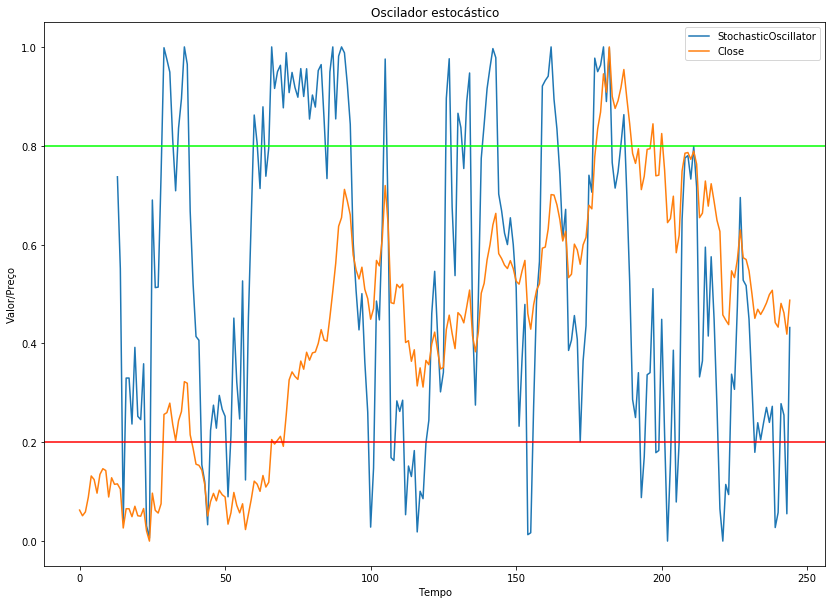

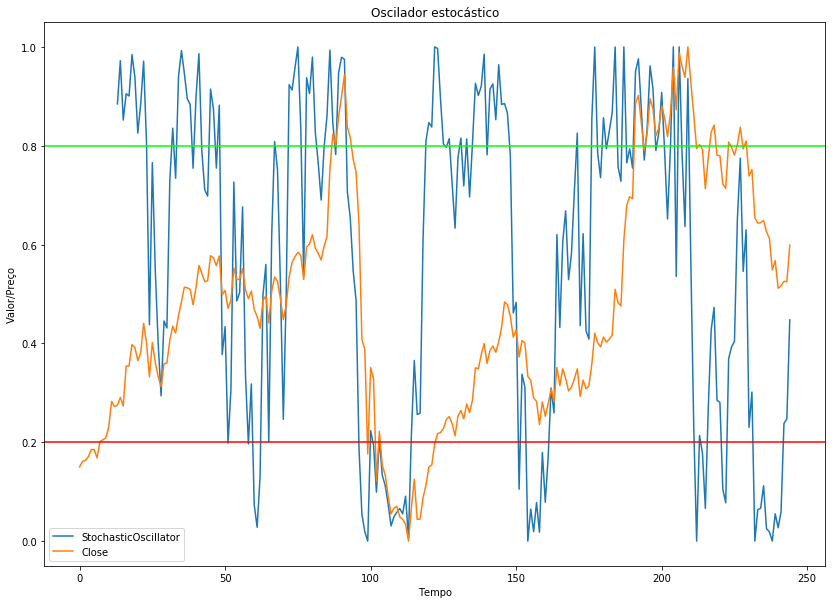

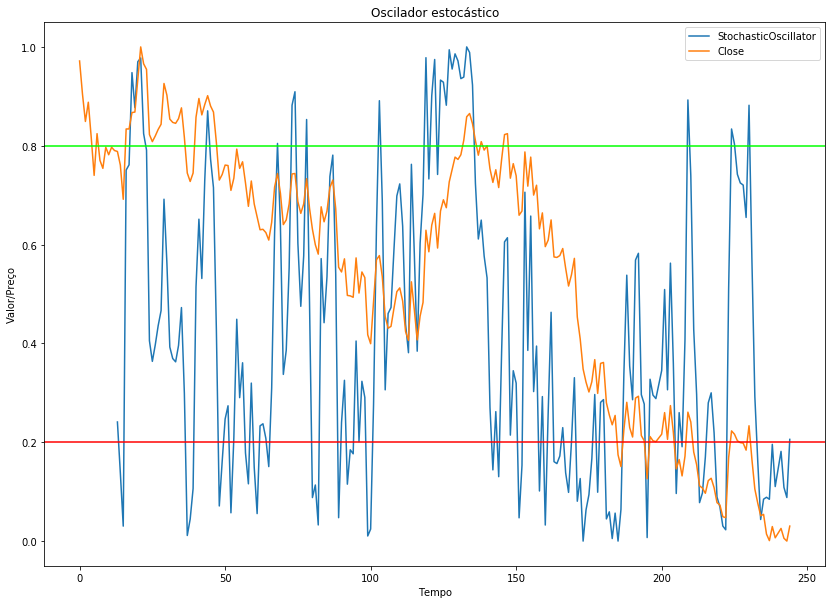

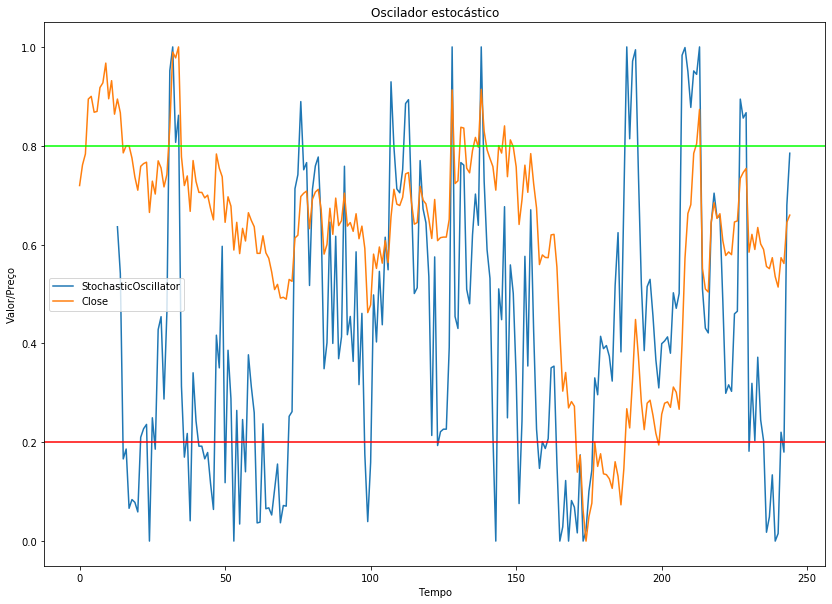

In [36]:
plot_stochastic_oscillator_all_stocks(historicStock)

<h2><b>Function to plot correlation matrix</b></h2>

In [37]:
def show_corr_matrix(stock, inflation=False):

    if inflation == False:
        corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "MoneyFlowIndex"]].corr()
    else:
        corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD", "InflationMoneyFlowIndex"]].corr()


    plt.figure(figsize = (10,10))
    sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
    plt.show()

In [38]:
def show_corr_matrix_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            corrMatrix = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "LongEMA", "MACD", "MoneyFlowIndex"]].corr()
        else:
            corrMatrix = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD", "InflationMoneyFlowIndex"]].corr()


        plt.figure(figsize = (10,10))
        sns.heatmap(corrMatrix, cmap='RdYlGn', center=0, annot=True)
        plt.show()

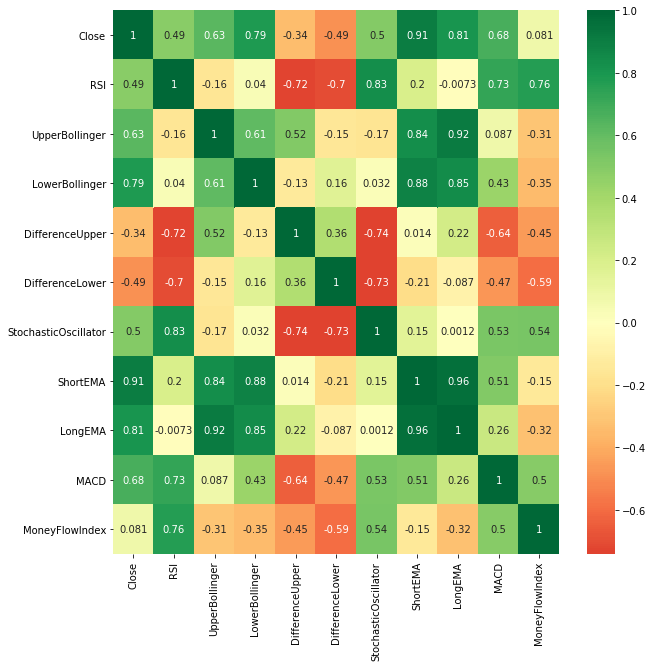

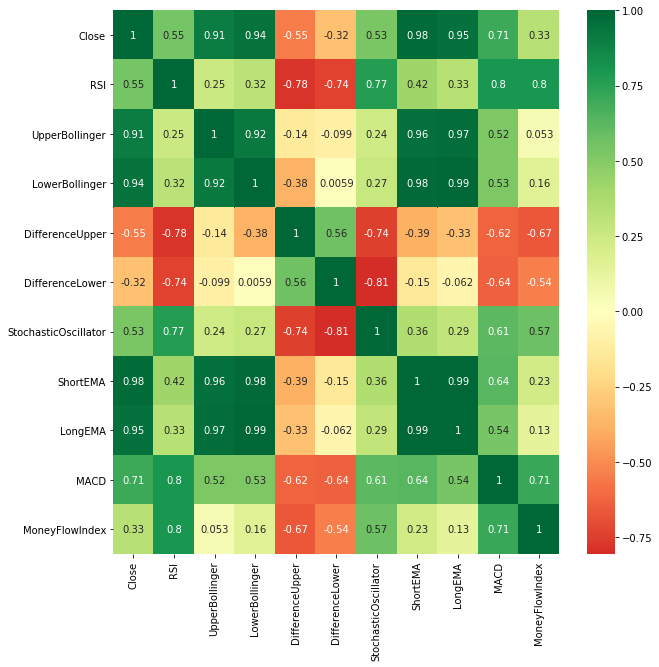

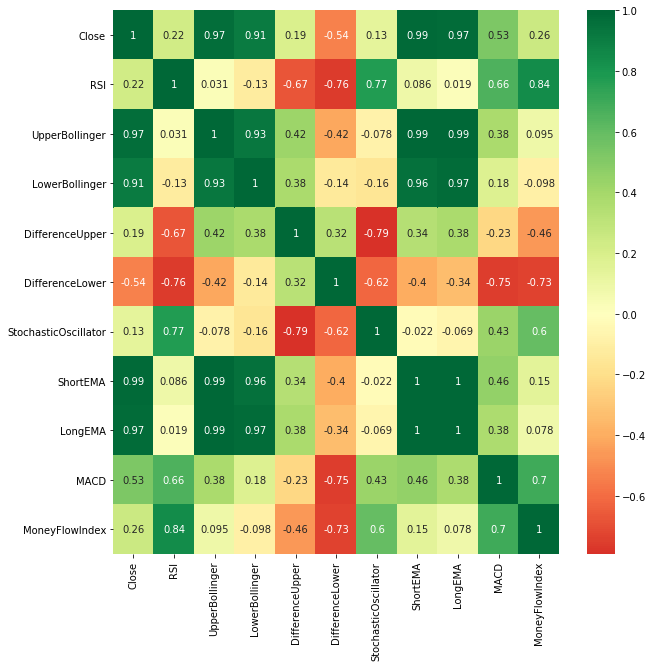

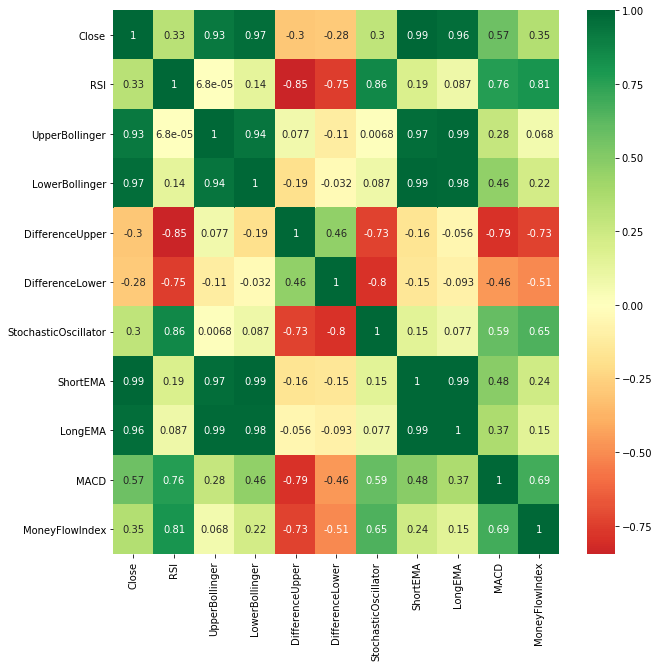

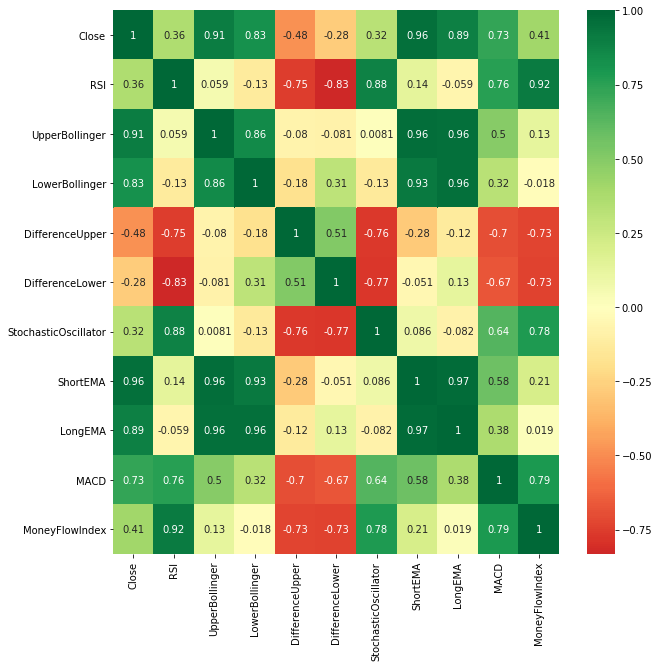

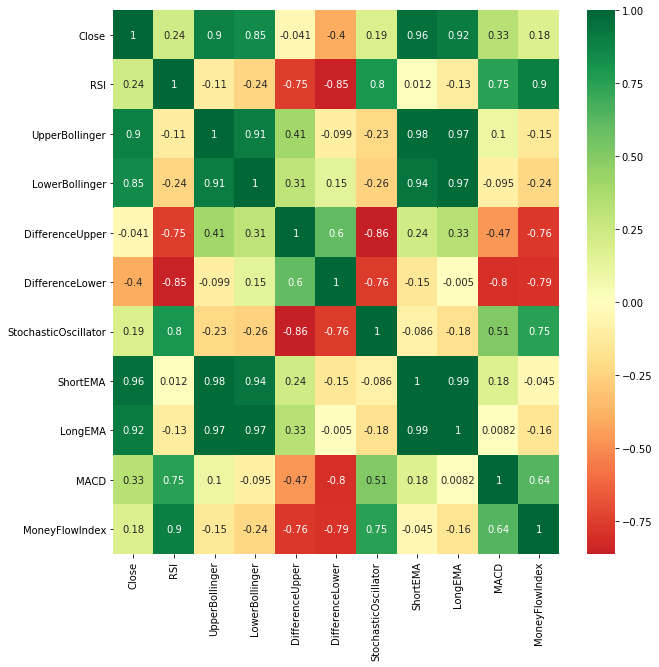

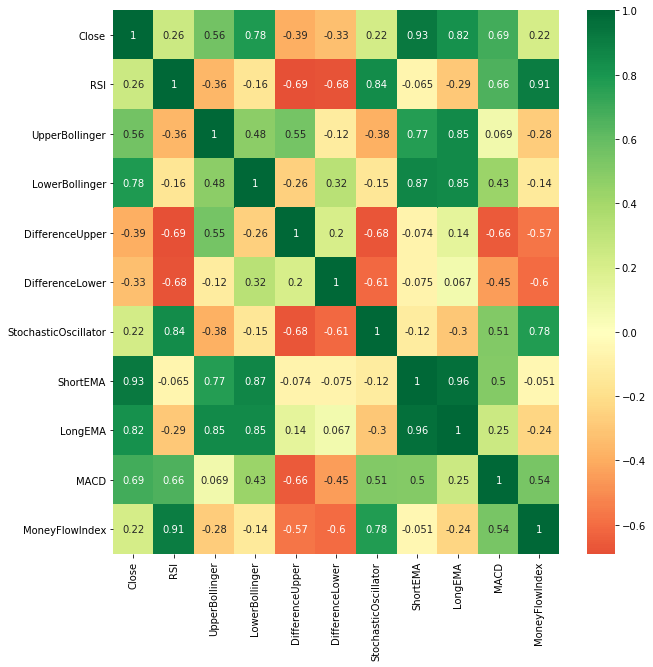

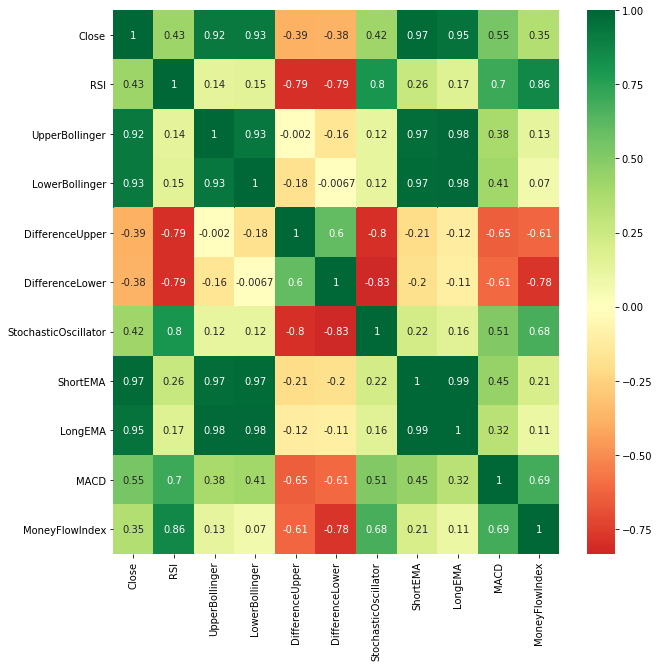

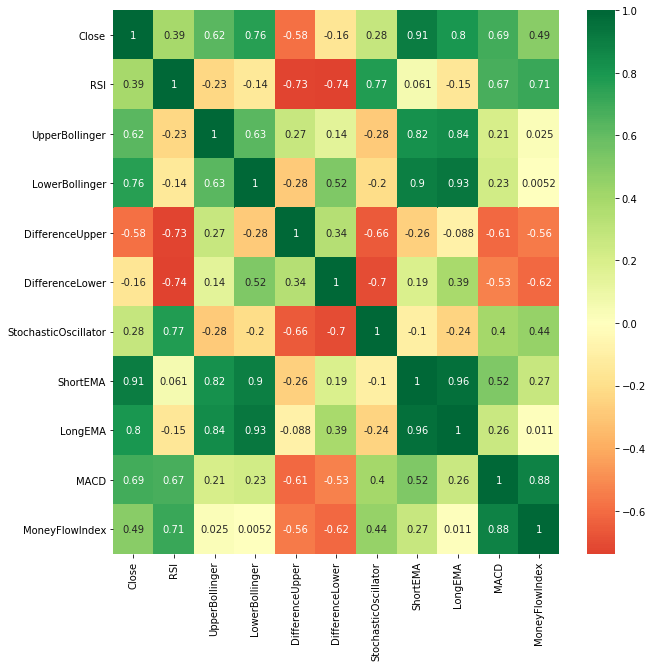

In [39]:
show_corr_matrix_all_stocks(historicStock)

<h2><b>Function to predict traditional SVM</b></h2>

In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [41]:
svmRegressorClose = svm.SVR(kernel="rbf")
svmRegressorNu = svm.NuSVR(kernel="rbf")

In [42]:
def predict_svm_traditional_two_stocks(stock, stock2, inflation=False, feature='close'):
    if feature == 'close':
        print(stock2.shape)
        print(stock.shape)
        stock2 = stock2.rename(columns={"Close":"close","RSI": "rsi", "UpperBollinger": "upperbollinger", "LowerBollinger": "lowerbollinger", "DifferenceUpper": "differenceupper", "DifferenceLower": "differencelower", "StochasticOscillator": "stochasticoscillator", "ShortEMA": "shortema", "MACD": "macd", "Close": "close"})
        stock2X = stock2[["close","rsi", "upperbollinger", "lowerbollinger", "differenceupper", "differencelower", "stochasticoscillator", "shortema", "macd"]][30:]
        if inflation == False:
            stockX = stock[["Close","RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockX = pd.concat([stockX, stock2X], axis=1)
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-5]
        y = y[5:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [1, 10, 100], 'kernel': ('linear', 'rbf')}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm.best_params_)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [163]:
def predict_svm_traditional(stock, inflation=False, feature='close'):
    if feature == 'close':
        if inflation == False:
            stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-3]
        y = y[3:]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
        
        parameters = {'C': [100], 'gamma': [0.0001]}
        
        gssvm = GridSearchCV(svmRegressorClose, parameters)

        gssvm.fit(X_train, y_train)
        print(gssvm.best_params_)


        y_pred = gssvm.predict(X_test)

#         print('Coefficients: \n', svmRegressorClose.coef_)

        return y_pred, y_test, y_train

In [164]:
def predict_plot_svm(stock, inflation=False, feature='close'):
    y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [165]:
def predict_plot_svm_all_stocks(stocks, inflation=False, feature='close'):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_traditional(stock, inflation, feature)

        y_pred = y_pred[3:]
        y_test = y_test[:-3]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'C': 100, 'gamma': 0.0001}
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1
 0 0 1 1 1 0 0 1 1 0 0 1]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0 0 1]


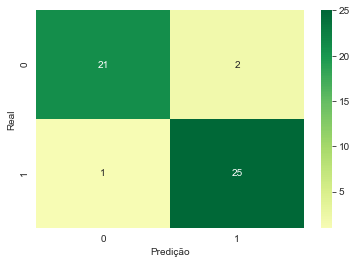

F1 score:  0.9433962264150944
Precision score:  0.9259259259259259
Accuracy score:  0.9387755102040817
MAE score:  0.29493333579674114
MSE value:  0.11034317320098835
RMSE value:  0.3321794292261162
MAPE value:  1.464336675635382


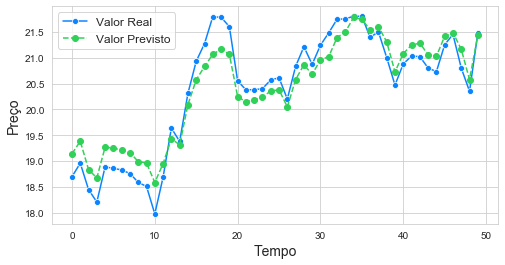

{'C': 100, 'gamma': 0.0001}
[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1
 1 0 0 0 1 0 1 0 0 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0 1 0]


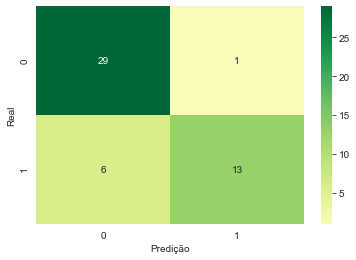

F1 score:  0.7878787878787878
Precision score:  0.9285714285714286
Accuracy score:  0.8571428571428571
MAE score:  0.2266902718863546
MSE value:  0.0596564191814854
RMSE value:  0.244246635967592
MAPE value:  13.334062930567917


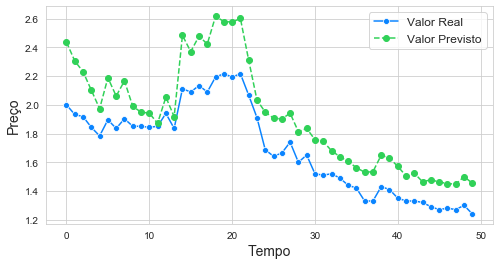

{'C': 100, 'gamma': 0.0001}
[0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 0 1 1 0 1 1 1 1 0 1]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1 1 1]


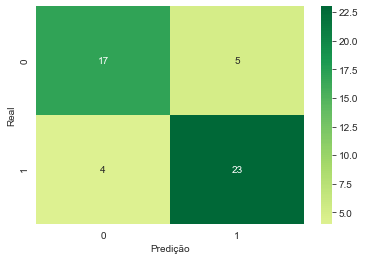

F1 score:  0.8363636363636364
Precision score:  0.8214285714285714
Accuracy score:  0.8163265306122449
MAE score:  0.2403757395167082
MSE value:  0.06948198651799513
RMSE value:  0.2635943597992854
MAPE value:  4.775376320855843


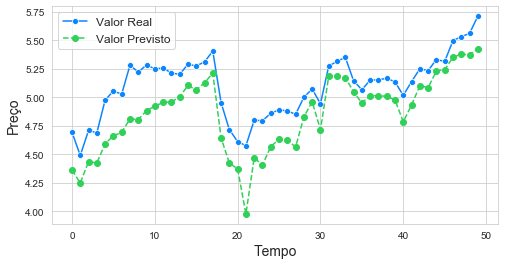

{'C': 100, 'gamma': 0.0001}
[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0 0 0]


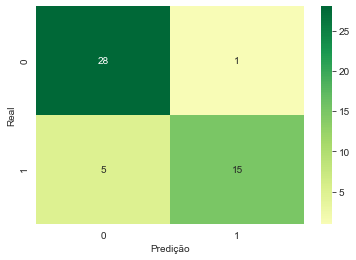

F1 score:  0.8333333333333334
Precision score:  0.9375
Accuracy score:  0.8775510204081632
MAE score:  0.23506460230550574
MSE value:  0.10581537070742836
RMSE value:  0.3252927461647867
MAPE value:  1.4670233682746743


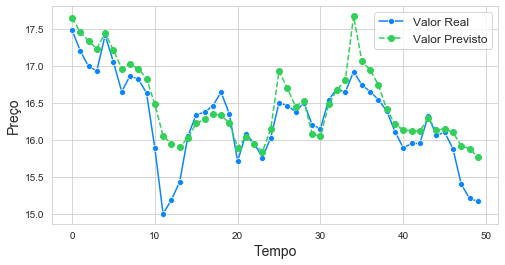

{'C': 100, 'gamma': 0.0001}
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1
 1 0 0 0 1 1 1 0 1 0 1 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1 1 1]


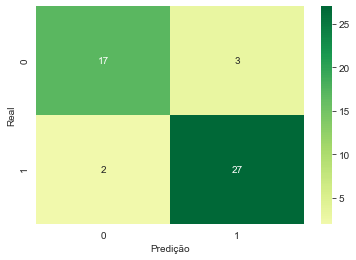

F1 score:  0.9152542372881356
Precision score:  0.9
Accuracy score:  0.8979591836734694
MAE score:  0.4193983080735423
MSE value:  0.2529078676229959
RMSE value:  0.5028994607503531
MAPE value:  0.9888302479550346


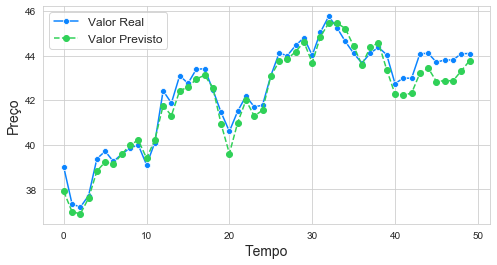

{'C': 100, 'gamma': 0.0001}
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0 0 0 0 1 1 1 0 1 1]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 0 1]


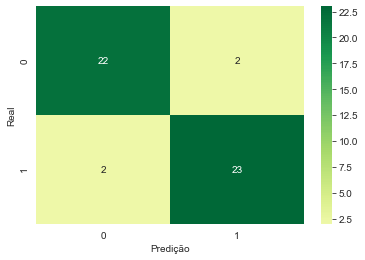

F1 score:  0.92
Precision score:  0.92
Accuracy score:  0.9183673469387755
MAE score:  1.4391590278700221
MSE value:  2.559524959164701
RMSE value:  1.5998515428516176
MAPE value:  2.658811322460187


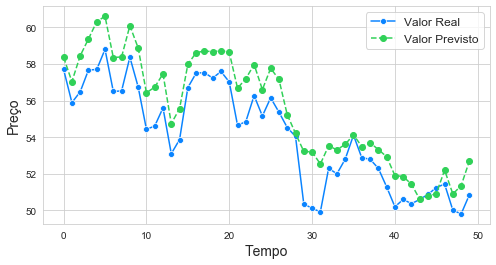

{'C': 100, 'gamma': 0.0001}
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1
 0 1 0 1 0 1 0 0 0 1 0 0]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 1]


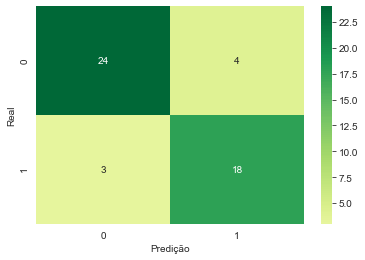

F1 score:  0.8372093023255814
Precision score:  0.8181818181818182
Accuracy score:  0.8571428571428571
MAE score:  2.1018353238191745
MSE value:  4.793906264989639
RMSE value:  2.189499089972325
MAPE value:  8.380731711534436


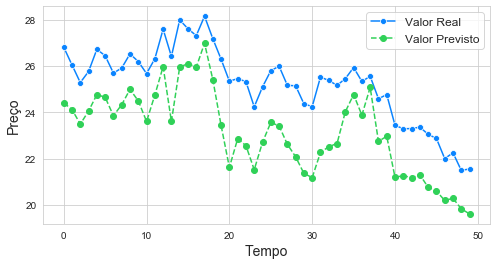

{'C': 100, 'gamma': 0.0001}
[0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0
 1 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1]


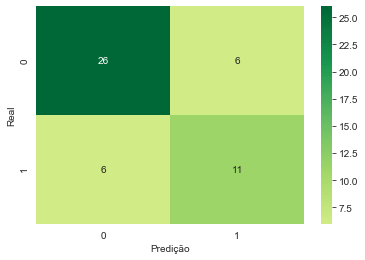

F1 score:  0.6470588235294118
Precision score:  0.6470588235294118
Accuracy score:  0.7551020408163265
MAE score:  0.7288999879658542
MSE value:  0.8982276026466266
RMSE value:  0.9477487022658626
MAPE value:  3.4393355424665533


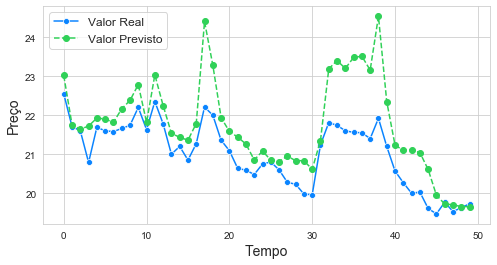

{'C': 100, 'gamma': 0.0001}
[0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0
 0 0 0 1 0 0 1 0 1 0 0 1]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0 0 1]


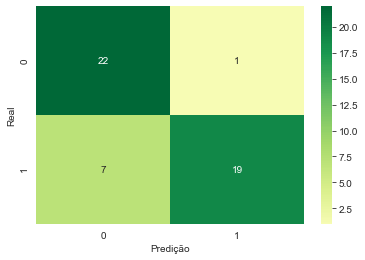

F1 score:  0.8260869565217392
Precision score:  0.95
Accuracy score:  0.8367346938775511
MAE score:  1.1847829260302631
MSE value:  2.2580066626296347
RMSE value:  1.5026665174381288
MAPE value:  2.1427645889582423


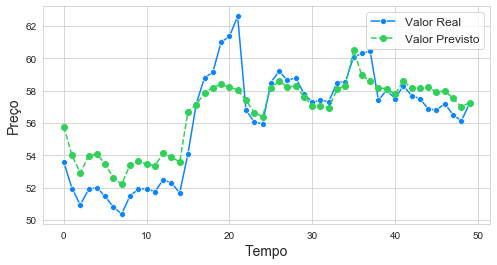

In [166]:
predict_plot_svm_all_stocks(historicStock)

<h2><b>Function to predict Nu SVM</b></h2>

In [167]:
def predict_svm_nu(stock, inflation=False):
    if inflation == False:
        stockX = stock[["Close", "RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-3]
    y = y[3:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'C': [100], 'nu': [0.5]}
    
    gssvm = GridSearchCV(svmRegressorNu, parameters)
    gssvm.fit(X_train, y_train)
    
    y_pred = gssvm.predict(X_test)
    
    print(gssvm.best_params_)

#     print('Coefficients: \n', svmRegressorNu.coef_)
    
    return y_pred, y_test, y_train

In [168]:
def predict_plot_svm_nu(stock, inflation=False):
    y_pred, y_test, y_train = predict_svm_nu(stock)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Nu SVM", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [169]:
def predict_plot_svm_nu_all_stocks(stocks, inflation=False):
    for stock in stocks:
        y_pred, y_test, y_train = predict_svm_nu(stock)

        y_pred = y_pred[3:]
        y_test = y_test[:-3]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        sns.set_style("whitegrid")
        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'C': 100, 'nu': 0.5}
[0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1
 0 0 1 1 1 0 1 1 1 0 0 1]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0 0 1]


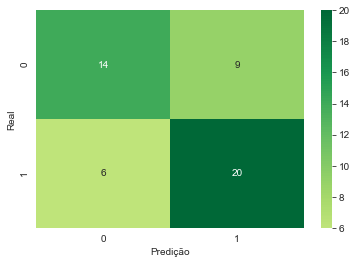

F1 score:  0.7272727272727274
Precision score:  0.6896551724137931
Accuracy score:  0.6938775510204082
MAE score:  0.3231064474292982
MSE value:  0.21563404678835596
RMSE value:  0.4643641316772388
MAPE value:  1.6311851384790446


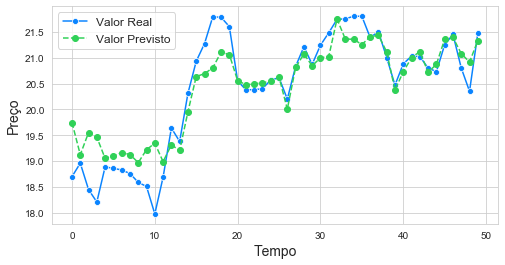

{'C': 100, 'nu': 0.5}
[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0 1 0]


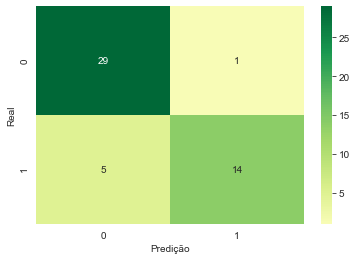

F1 score:  0.8235294117647058
Precision score:  0.9333333333333333
Accuracy score:  0.8775510204081632
MAE score:  0.15240746081433504
MSE value:  0.046298647311866566
RMSE value:  0.21517120465310074
MAPE value:  8.07517146570448


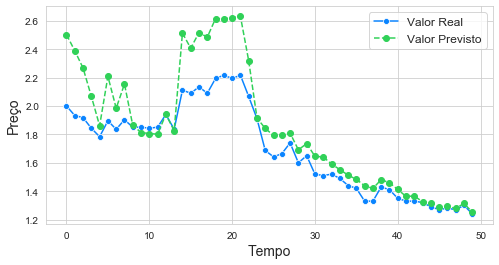

{'C': 100, 'nu': 0.5}
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0
 0 0 0 1 1 0 1 1 1 1 0 0]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1 1 1]


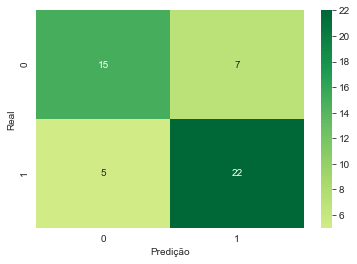

F1 score:  0.7857142857142857
Precision score:  0.7586206896551724
Accuracy score:  0.7551020408163265
MAE score:  0.20262534066527457
MSE value:  0.06169862940450905
RMSE value:  0.24839208804732296
MAPE value:  4.061617065629059


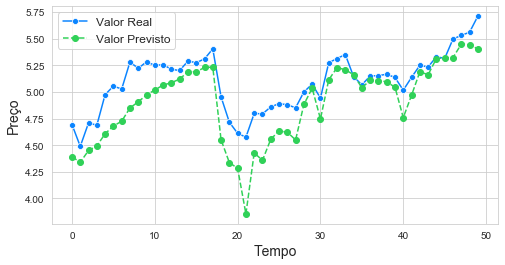

{'C': 100, 'nu': 0.5}
[0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0
 0 0 0 1 0 1 0 1 0 0 1 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0 0 0]


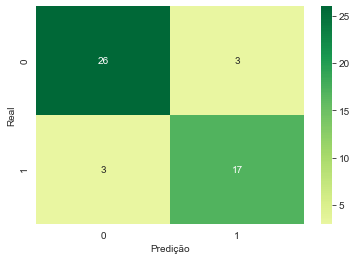

F1 score:  0.85
Precision score:  0.85
Accuracy score:  0.8775510204081632
MAE score:  0.34905036950344803
MSE value:  0.18243059591080266
RMSE value:  0.42711894819921375
MAPE value:  2.1877190035163405


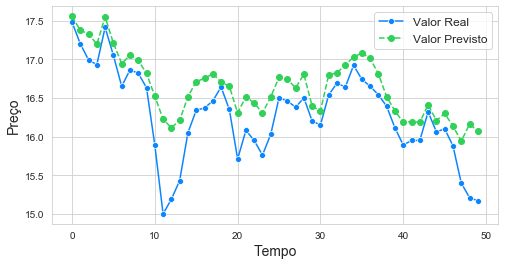

{'C': 100, 'nu': 0.5}
[0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 1 1 1 0 0 0 1 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1 1 1]


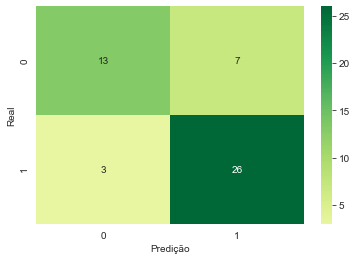

F1 score:  0.8387096774193549
Precision score:  0.7878787878787878
Accuracy score:  0.7959183673469388
MAE score:  0.4783313931935355
MSE value:  0.40644806598864996
RMSE value:  0.6375327960102523
MAPE value:  1.151057339369459


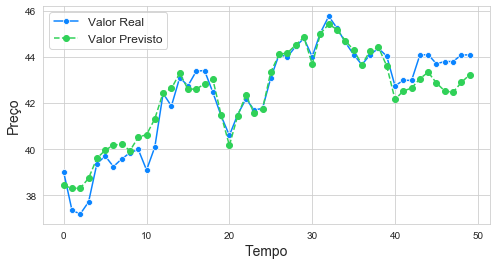

{'C': 100, 'nu': 0.5}
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1
 0 0 0 1 0 0 1 1 1 0 1 1]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 0 1]


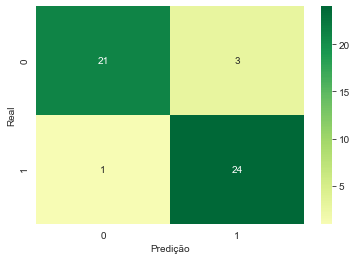

F1 score:  0.923076923076923
Precision score:  0.8888888888888888
Accuracy score:  0.9183673469387755
MAE score:  1.0630324999344003
MSE value:  1.3768921518984876
RMSE value:  1.1734104788600142
MAPE value:  1.9595564094862714


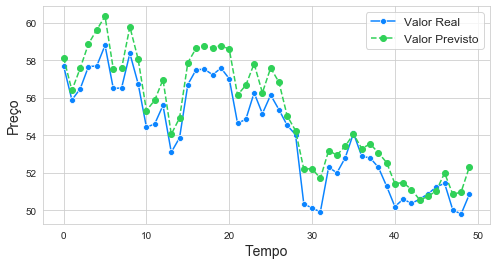

{'C': 100, 'nu': 0.5}
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1
 0 1 0 1 0 0 0 0 0 1 0 0]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 1]


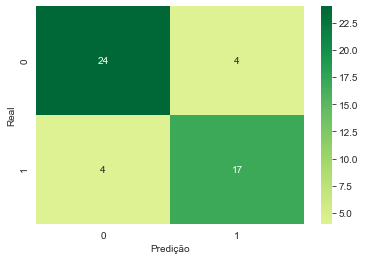

F1 score:  0.8095238095238095
Precision score:  0.8095238095238095
Accuracy score:  0.8367346938775511
MAE score:  2.3054950740550715
MSE value:  5.708814224399042
RMSE value:  2.3893125003647055
MAPE value:  9.15130505644576


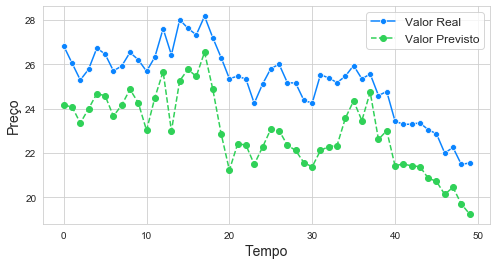

{'C': 100, 'nu': 0.5}
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0
 1 0 0 0 0 0 0 1 1 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1]


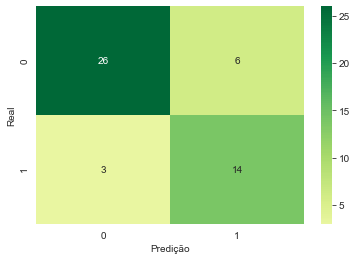

F1 score:  0.7567567567567567
Precision score:  0.7
Accuracy score:  0.8163265306122449
MAE score:  0.4804665151006372
MSE value:  0.4956360260062757
RMSE value:  0.7040142228721489
MAPE value:  2.2488854660583613


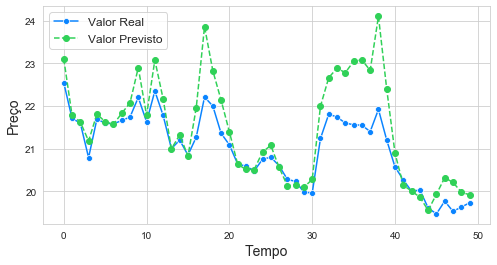

{'C': 100, 'nu': 0.5}
[0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 1]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0 0 1]


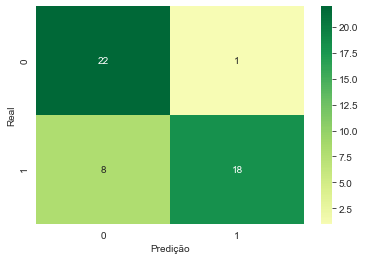

F1 score:  0.7999999999999999
Precision score:  0.9473684210526315
Accuracy score:  0.8163265306122449
MAE score:  1.2055233766927016
MSE value:  2.53850387739603
RMSE value:  1.5932683005056085
MAPE value:  2.1842502151772027


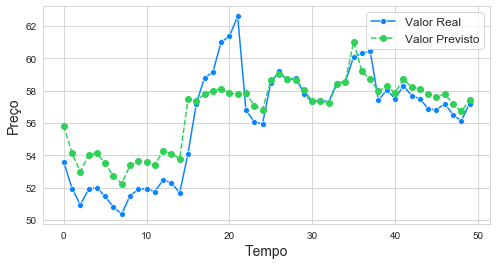

In [170]:
predict_plot_svm_nu_all_stocks(historicStock)

<h2><b>Scaling data for LSTM</b></h2>

In [51]:
# scaler = MinMaxScaler()
# stockScaled = []
# stocksScaled = []

# for stock in historicStock:
#     stocksScaled.append(stock)
    
# for stock in stocksScaled:
#     stockScaled.append(pd.DataFrame(scaler.fit_transform(stock), columns=historicStock[0].columns))

In [52]:
# def predict_LSTM(stock, inflation=False):
#     if inflation == False:
#         stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
#         stockY = stock["Close"][30:]
#     else:
#         stockX = stock[["InflationRSI", "InflationMoneyFlowIndex", "InflationStochasticOscillator", "InflationShortEMA", "InflationMACD"]][15:]
#         stockY = stock["InflationClose"][15:]
#     X = np.array(stockX)
#     y = np.array(stockY)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
#     X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
#     X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#     y_train = y_train.reshape(y_train.shape[0], 1, 1)
#     y_test = y_test.reshape(y_test.shape[0], 1, 1)
    
#     model = Sequential()

#     model.add(LSTM(128, activation='sigmoid', input_shape=(8,1)))
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(128, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(32, activation='sigmoid'))
#     model.add(Dropout(0.2))
    
#     model.add(Dense(10, activation='softmax'))
#     model.add(Dropout(0.2))
    
#     model.compile(optimizer=Adam(lr=1e-3, decay=1e-5), metrics=['accuracy'])
    
#     model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))

In [53]:
# predict_LSTM(stockScaled[0])

<h2><b>Function to predict with Kernel Ridge Regression</b></h2>

In [54]:
clf = KernelRidge(alpha=1.0, kernel='rbf')

In [140]:
def predict_kernel_ridge(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)
    
    parameters = {'alpha': [1], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

    clf = KernelRidge(alpha=1.0)
    gssvm = GridSearchCV(clf, parameters, scoring = 'neg_mean_squared_error')
    gssvm.fit(X_train, y_train)
        
    y_pred = gssvm.predict(X_test)
    
    print(gssvm.best_params_)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (6,4))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    sns.set_style("whitegrid")
    plt.figure(figsize = (8,4))
    sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Kernel Ridge", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [177]:
def predict_kernel_ridge_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["Close","RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-3]
        y = y[3:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        parameters = {'alpha': [1], 'gamma': [1]}

        clf = KernelRidge(alpha=1.0)
        gssvm = GridSearchCV(clf, parameters, scoring = 'neg_mean_squared_error')
        gssvm.fit(X_train, y_train)

        y_pred = gssvm.predict(X_test)

        print(gssvm.best_params_)

        y_pred = y_pred[3:]
        y_test = y_test[:-3]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))


        sns.set_style("whitegrid")
        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

{'alpha': 1, 'gamma': 1}
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0 0 1]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0 0 1]


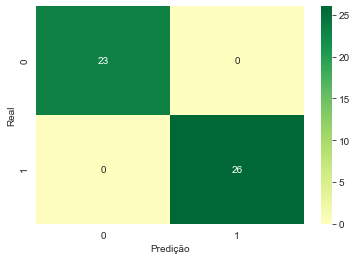

F1 score:  1.0
Precision score:  1.0
Accuracy score:  1.0
MAE score:  0.34746150737959397
MSE value:  0.18596431362692806
RMSE value:  0.4312357981741869
MAPE value:  1.6886197275920234


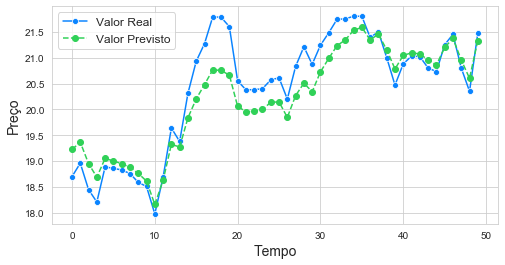

{'alpha': 1, 'gamma': 1}
[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0 1 0]


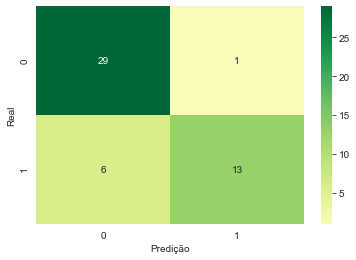

F1 score:  0.7878787878787878
Precision score:  0.9285714285714286
Accuracy score:  0.8571428571428571
MAE score:  0.06664832296076724
MSE value:  0.0062512896600521554
RMSE value:  0.07906509760983133
MAPE value:  3.8898692118219675


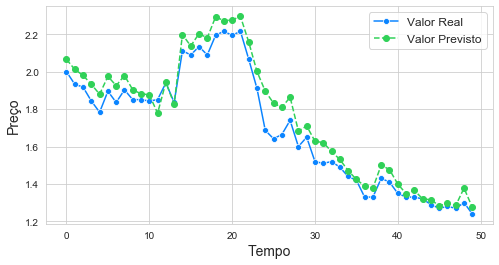

{'alpha': 1, 'gamma': 1}
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 1 1 0 1 0 1 1]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1 1 1]


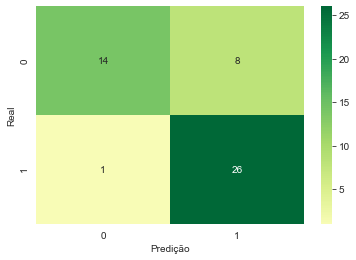

F1 score:  0.8524590163934426
Precision score:  0.7647058823529411
Accuracy score:  0.8163265306122449
MAE score:  0.1390546345737812
MSE value:  0.03826719496271635
RMSE value:  0.19562002699804626
MAPE value:  2.7408723693262607


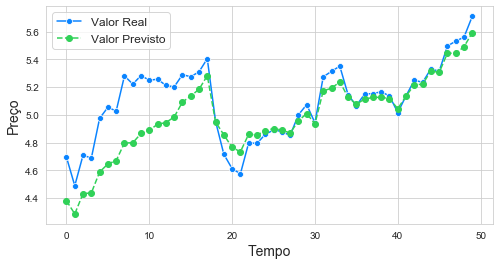

{'alpha': 1, 'gamma': 1}
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0 0 0]


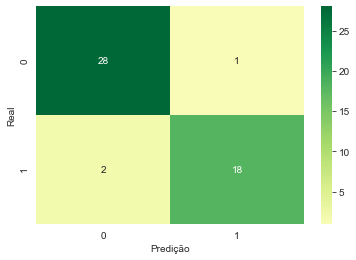

F1 score:  0.9230769230769231
Precision score:  0.9473684210526315
Accuracy score:  0.9387755102040817
MAE score:  0.12517921776137655
MSE value:  0.021952531468691108
RMSE value:  0.14816386694700942
MAPE value:  0.7682402523640014


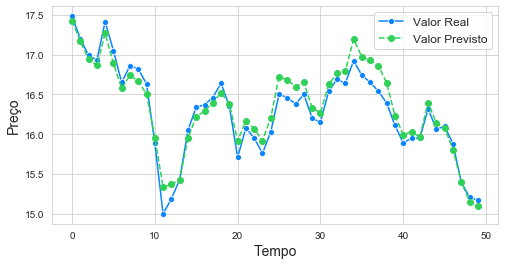

{'alpha': 1, 'gamma': 1}
[0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1
 1 0 0 0 0 1 1 0 1 1 1 1]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1 1 1]


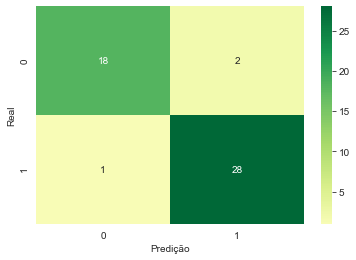

F1 score:  0.9491525423728815
Precision score:  0.9333333333333333
Accuracy score:  0.9387755102040817
MAE score:  0.6518828624760499
MSE value:  0.6438656852118712
RMSE value:  0.8024124159133327
MAPE value:  1.5745540411100518


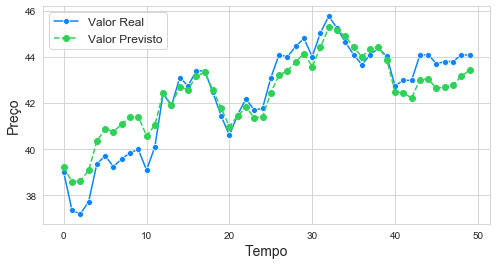

{'alpha': 1, 'gamma': 1}
[0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 0 1]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 0 1]


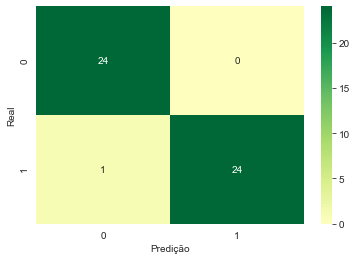

F1 score:  0.9795918367346939
Precision score:  1.0
Accuracy score:  0.9795918367346939
MAE score:  0.6099402172671398
MSE value:  0.46823263715400015
RMSE value:  0.6842752641693255
MAPE value:  1.124221153606198


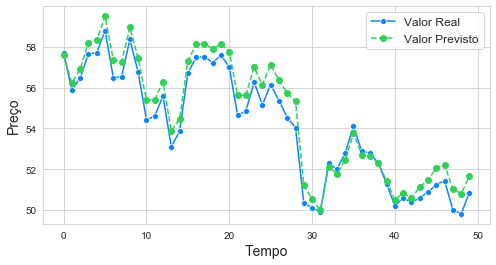

{'alpha': 1, 'gamma': 1}
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1
 0 1 0 1 1 1 0 0 0 1 0 0]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 1]


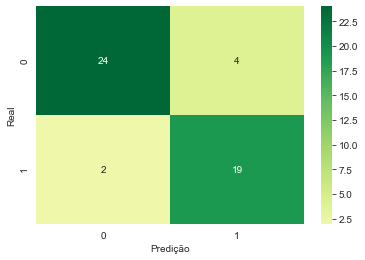

F1 score:  0.8636363636363636
Precision score:  0.8260869565217391
Accuracy score:  0.8775510204081632
MAE score:  1.2514228718382219
MSE value:  3.005562754767439
RMSE value:  1.7336558928367067
MAPE value:  4.835580061350761


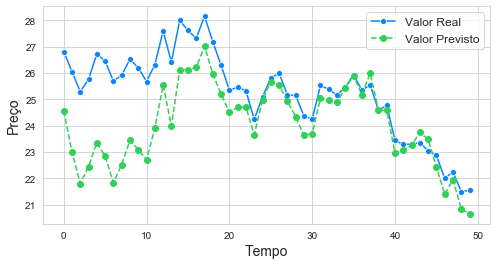

{'alpha': 1, 'gamma': 1}
[0 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1]


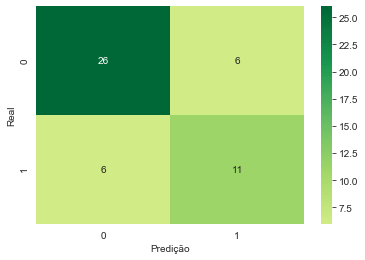

F1 score:  0.6470588235294118
Precision score:  0.6470588235294118
Accuracy score:  0.7551020408163265
MAE score:  0.34166511214873024
MSE value:  0.1638123144940488
RMSE value:  0.4047373401281982
MAPE value:  1.636553936086128


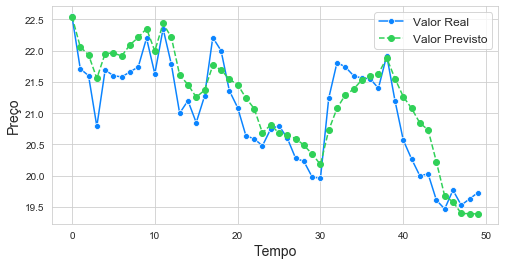

{'alpha': 1, 'gamma': 1}
[0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 0 0 1]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0 0 1]


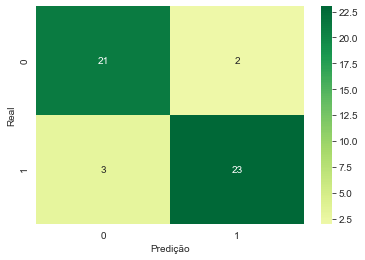

F1 score:  0.9019607843137256
Precision score:  0.92
Accuracy score:  0.8979591836734694
MAE score:  1.6696872094474384
MSE value:  4.224769955644009
RMSE value:  2.0554245195686485
MAPE value:  2.875721215455131


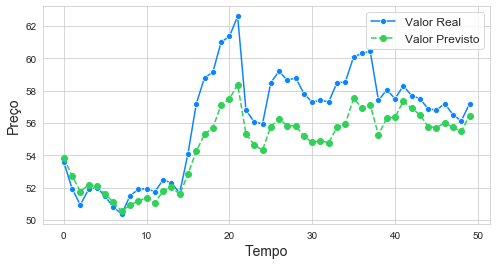

In [178]:
predict_kernel_ridge_all_stocks(historicStock)

<h2><b>Function to predict with Linear Regression</b></h2>

In [155]:
regr = linear_model.LinearRegression()

In [156]:
def predict_linear(stock, stock2, inflation=False):
    print(stock2.shape)
    print(stock.shape)
    stock2 = stock2.rename(columns={"RSI": "rsi", "UpperBollinger": "upperbollinger", "LowerBollinger": "lowerbollinger", "DifferenceUpper": "differenceupper", "DifferenceLower": "differencelower", "StochasticOscillator": "stochasticoscillator", "ShortEMA": "shortema", "MACD": "macd", "Close": "close"})
    stock2X = stock2[["rsi", "upperbollinger", "lowerbollinger", "differenceupper", "differencelower", "stochasticoscillator", "shortema", "macd"]][30:]
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockX = pd.concat([stockX, stock2X], axis=1)
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [157]:
def predict_linear(stock, inflation=False):
    if inflation == False:
        stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
        stockY = stock["Close"][30:]
    else:
        stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
        stockY = stock["InflationClose"][30:]
    X = np.array(stockX)
    y = np.array(stockY)
    X = X[:-5]
    y = y[5:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    y_pred = y_pred[5:]
    y_test = y_test[:-5]
    
    predictUpDown = upOrDownNpArray(y_pred)
    realUpDown = upOrDownNpArray(y_test)
    
    print(predictUpDown)
    print(realUpDown)
    
    i = 0
    count = 0
    
    plt.figure(figsize = (10,8))
    
    matrix = confusion_matrix(realUpDown, predictUpDown)
    sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)
    
    plt.xlabel('Predição')
    plt.ylabel('Real')
    plt.title('Matriz de confusão')
    plt.show()
    
#     print('Coefficients: \n', regr.coef_)
    
    print('F1 score: ', f1_score(realUpDown, predictUpDown))
    print('Precision score: ', precision_score(realUpDown, predictUpDown))
    print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
    print('MAE score: ', mean_absolute_error(y_test, y_pred))
    print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
    print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
    print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))
    
    plt.figure(figsize = (14,10))
    sns.set_style("whitegrid")
    sns.lineplot(data=y_test, label="Valor Real", color = '#0a84ff')
    plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=10, label="Valor Previsto", color="#30d158")
    plt.title("Predição da ação usando Regressão Linear", fontsize=18)
    plt.xlabel('Tempo', fontsize=14)
    plt.ylabel('Preço', fontsize=14)
    plt.legend(fontsize=12)
    plt.show()

In [184]:
def predict_linear_all_stocks(stocks, inflation=False):
    for stock in stocks:
        if inflation == False:
            stockX = stock[["RSI", "UpperBollinger", "LowerBollinger", "DifferenceUpper", "DifferenceLower", "StochasticOscillator", "ShortEMA", "MACD"]][30:]
            stockY = stock["Close"][30:]
        else:
            stockX = stock[["InflationClose", "InflationRSI", "InflationUpperBollinger", "InflationLowerBollinger", "InflationDifferenceUpper", "InflationDifferenceLower", "InflationStochasticOscillator", "InflationShortEMA", "InflationLongEMA", "InflationMACD"]][30:]
            stockY = stock["InflationClose"][30:]
        X = np.array(stockX)
        y = np.array(stockY)
        X = X[:-3]
        y = y[3:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=False)

        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_test)

        y_pred = y_pred[3:]
        y_test = y_test[:-3]

        predictUpDown = upOrDownNpArray(y_pred)
        realUpDown = upOrDownNpArray(y_test)

        print(predictUpDown)
        print(realUpDown)

        i = 0
        count = 0

        plt.figure(figsize = (6,4))

        matrix = confusion_matrix(realUpDown, predictUpDown)
        sns.heatmap(matrix, cmap='RdYlGn', center=0, annot=True)

        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

    #     print('Coefficients: \n', regr.coef_)

        print('F1 score: ', f1_score(realUpDown, predictUpDown))
        print('Precision score: ', precision_score(realUpDown, predictUpDown))
        print('Accuracy score: ', accuracy_score(realUpDown, predictUpDown))
        print('MAE score: ', mean_absolute_error(y_test, y_pred))
        print('MSE value: ', mean_squared_error(y_test, y_pred, squared=True))
        print('RMSE value: ', mean_squared_error(y_test, y_pred, squared=False))
        print('MAPE value: ', mean_absolute_percentage_error(y_test, y_pred))

        sns.set_style("whitegrid")
        plt.figure(figsize = (8,4))
        sns.lineplot(data=y_test, label="Valor Real", marker="o", markersize=6, color = '#0a84ff')
        plt.plot(range(len(y_pred)), y_pred, linestyle='--', marker="o", markersize=6, label="Valor Previsto", color="#30d158")
        plt.xlabel('Tempo', fontsize=14)
        plt.ylabel('Preço', fontsize=14)
        plt.legend(fontsize=12)
        plt.show()

[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0 0 1]
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 1 0 0 0 1 1 0 0 1]


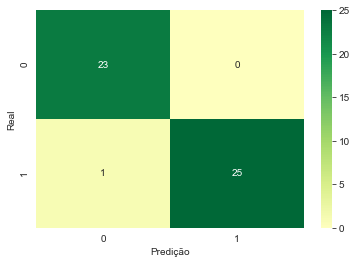

F1 score:  0.9803921568627451
Precision score:  1.0
Accuracy score:  0.9795918367346939
MAE score:  0.3949201461504089
MSE value:  0.24874479543284708
RMSE value:  0.49874321592664
MAPE value:  1.9066575142146345


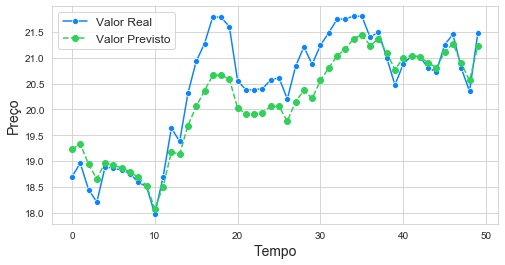

[0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 1 0]
[0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 1 0 1 0]


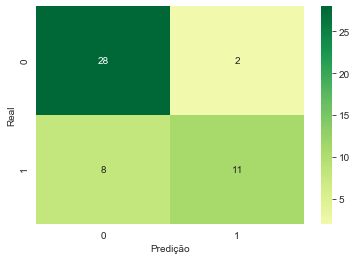

F1 score:  0.6875
Precision score:  0.8461538461538461
Accuracy score:  0.7959183673469388
MAE score:  0.06801799660034813
MSE value:  0.008677099974289568
RMSE value:  0.09315095262148192
MAPE value:  3.8911384085521985


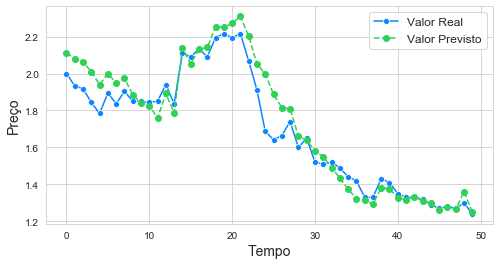

[0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 0 0 1 1 1 1 1 1 0 1]
[0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 1 1 0 1 0 1 1 1 1]


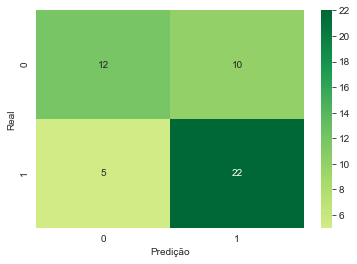

F1 score:  0.7457627118644067
Precision score:  0.6875
Accuracy score:  0.6938775510204082
MAE score:  0.24550816576431772
MSE value:  0.08639695621096212
RMSE value:  0.29393359149808335
MAPE value:  4.820079141267778


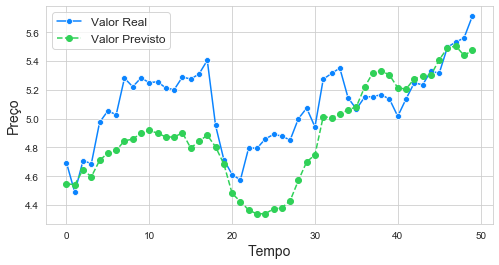

[0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 1 1 0 1 0 0 0 0]


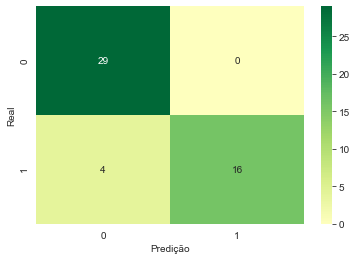

F1 score:  0.888888888888889
Precision score:  1.0
Accuracy score:  0.9183673469387755
MAE score:  0.17139138983480565
MSE value:  0.03895786686635169
RMSE value:  0.19737747304682896
MAPE value:  1.050095651183754


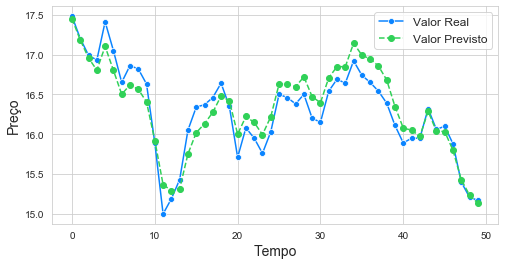

[0 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 1 1 0 0 0]
[0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1
 1 0 0 1 0 1 1 0 1 1 1 1]


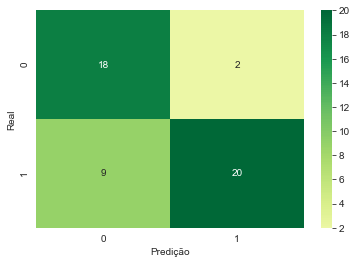

F1 score:  0.7843137254901961
Precision score:  0.9090909090909091
Accuracy score:  0.7755102040816326
MAE score:  1.2642665997391225
MSE value:  2.6519699974168303
RMSE value:  1.6284870270950365
MAPE value:  3.0965500143797358


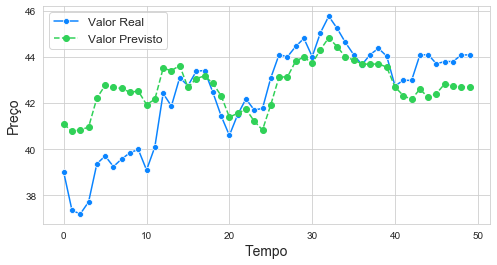

[0 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0 1 0 1 1 1 1 0 0 1]
[0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 1 0 0 1]


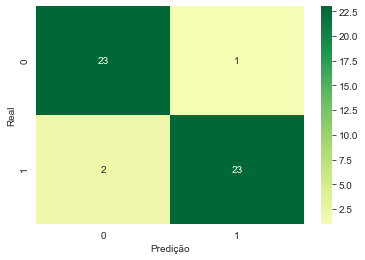

F1 score:  0.9387755102040817
Precision score:  0.9583333333333334
Accuracy score:  0.9387755102040817
MAE score:  0.5096366804742994
MSE value:  0.33015634893746504
RMSE value:  0.5745923328216841
MAPE value:  0.9433181068586958


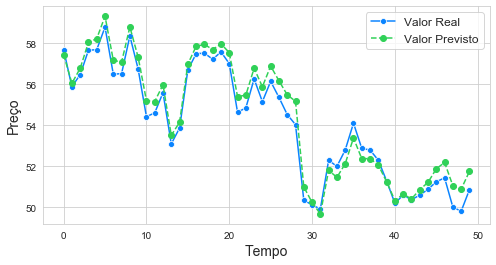

[0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 1 1 1 0 0 0 1 0 0]
[0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 1
 0 1 0 0 1 1 0 0 0 1 0 1]


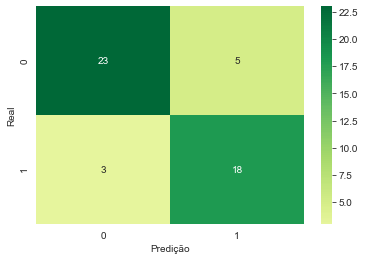

F1 score:  0.8181818181818182
Precision score:  0.782608695652174
Accuracy score:  0.8367346938775511
MAE score:  1.2877565431852553
MSE value:  3.3969549209958085
RMSE value:  1.8430829935181456
MAPE value:  4.973051221506332


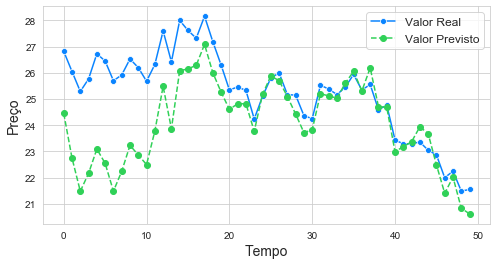

[0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1]


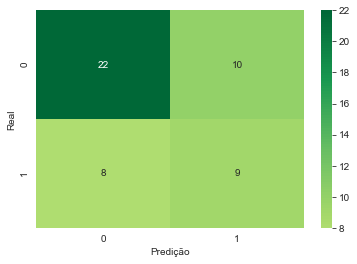

F1 score:  0.5
Precision score:  0.47368421052631576
Accuracy score:  0.6326530612244898
MAE score:  1.2062073926028436
MSE value:  1.645424225529046
RMSE value:  1.282740903506646
MAPE value:  5.789674290076569


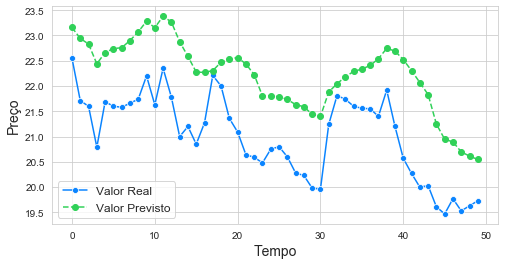

[0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0
 0 1 0 1 0 0 0 0 1 0 0 1]
[0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 1 0 0 1]


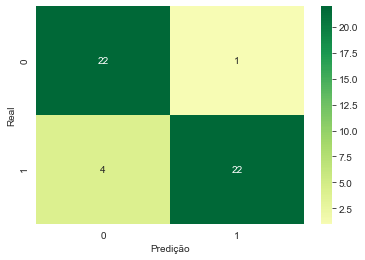

F1 score:  0.8979591836734695
Precision score:  0.9565217391304348
Accuracy score:  0.8979591836734694
MAE score:  1.6998547823923968
MSE value:  4.036431355761852
RMSE value:  2.0090871946637487
MAPE value:  3.1399230861420246


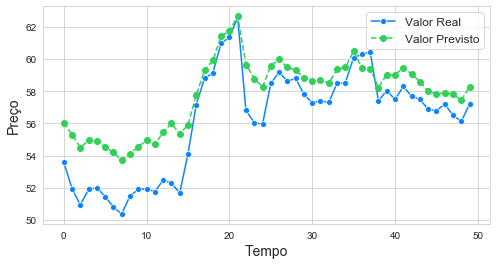

In [185]:
predict_linear_all_stocks(historicStock)